<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.316 Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 12 : Deep Learning


<a name='section_12_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.0 Overview</h2>



This lecture will introduce important core concepts in deep learning.

The slides can be found [here](https://www.dropbox.com/s/3oyuooca8et474z/mit_8S50_deeplearning.pdf?dl=0)

    

### Setup

We will use PyTorch. You can set this up with below. Additionally, we will need Pandas to load the datsets that we will use today. 

In [1]:
#!pip install torch
#!pip install pandas
#!pip install h5py
import torch
print(torch.__version__)

1.13.1


You should see the PyTorch version printed properly.

In [2]:
#>>>RUN: L10.0-runcell01

import numpy as np
import lmfit
import matplotlib.pyplot as plt
from scipy import stats
import torch 
from scipy import optimize as opt
import h5py
import pandas as pd


For this class, we are also going to use some crystal data from CMS. Lets go ahead and download it, if you haven't already. 

In [3]:
#download file
filename = 'data/xtalTuple_TTbar_PU0.z'
#!wget https://www.dropbox.com/s/tddxh4hfi5n4lm8/xtalTuple_TTbar_PU0.z?dl=0
#!mv xtalTuple_TTbar_PU0.z?dl=0 data/xtalTuple_TTbar_PU0.z


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [3]:
#>>>RUN: L10.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<a name='section_9_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.1 Machine Learning </h2>  





Machine learning (ML) broadly describes the methods by which computers are able to learn mathematical models to describe data. If this sounds a little familiar don't be surprised: ML at its core is fitting.

ML involves three main components:

- Model
    - chosen mathematical model (depends on the task / available data)
- Learning
    - estimate statistical model from data 
- Prediction/Inference
    - use statistical model to make predictions on new data points and infer properties

### Supervised Learning

Given N examples with features ${x_i\in X}$ and targets ${y_i\in Y}$, learn function mapping $h(x)=y$.

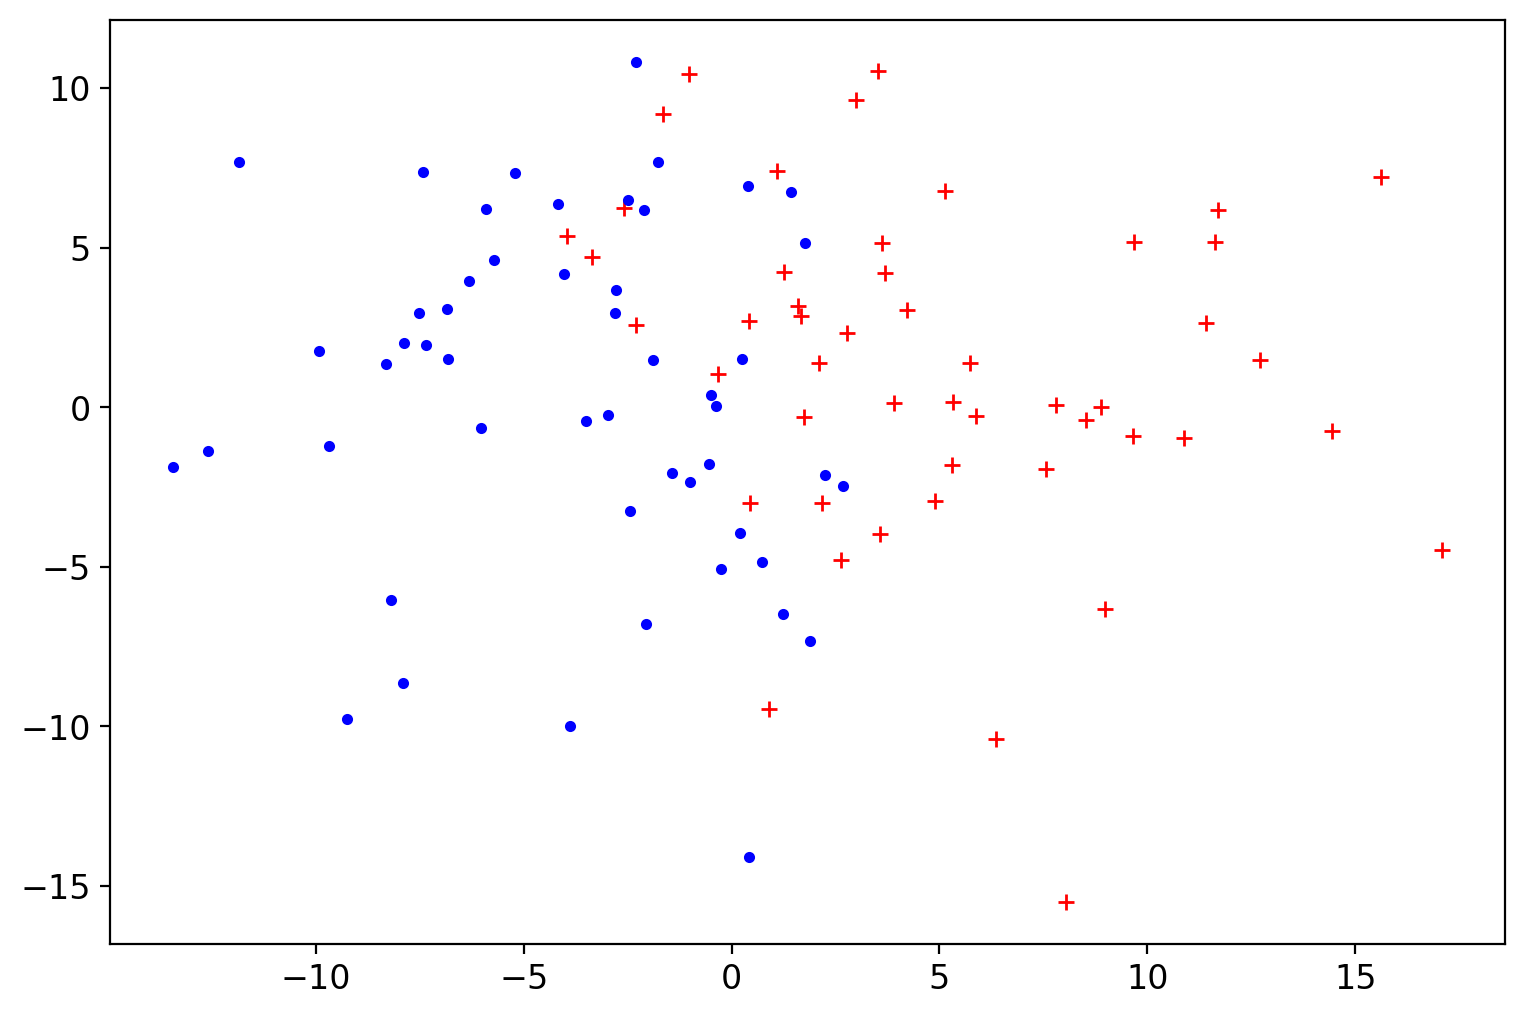

In [4]:
#define points
x1 = np.random.normal(0, 5, 100) #mean, sigma, num_points
x2 = np.random.normal(0, 5, 100)


mask_pos = x2 > (2. - 3.*x1)
mask_neg = x2 <= (2. - 3.*x1)

noise = 2 #sets the noise scale
x1noise = np.random.normal(0, noise, 100)
x2noise = np.random.normal(0, noise, 100)

x1 = x1 + x1noise
x2 = x2 + x2noise

# lets define a true boundary between the two classes
# by x_2 = 2 - 3 x_1
x1_pos = x1[mask_pos]
x2_pos = x2[mask_pos]
x1_neg = x1[mask_neg]
x2_neg = x2[mask_neg]

#look at things
plt.plot(x1_pos, x2_pos, 'r+')
plt.plot(x1_neg, x2_neg, 'b.')

plt.show()

#### Classification

In classification tasks, $Y$ is a finite set of labels (i.e. classes). Can be:

- Binary classification ($Y={0,1}$) e.g. signal vs. background (or blue vs. red as we have here)

- Multi-class classification ($Y={c_1,c_2,...,c_n}$) e.g. blue vs. red vs. green, or is this particle an electron or pion or photon? 
    - Multi-class labels are typically represented using "one-hot-encoding" or "one-hot-vectors": $y_i=(0,0,...,1,...,0)$ where the kth element is 1 and all other are 0 for class $c_k$.
        - For case of blue vs. red vs. green we could encode blue as $y_0=(1,0,0)$, red as $y_1=(0,1,0)$, green as $y_2=(0,0,1)$

#### Regression

In regression tasks, $Y$ is the real numbers
    - Instead of color, a real number at each point (equivalent to a 3-d scatter plot)

#### Procedure

- Design a function (model) with adjustable parameters
- Design a loss function
- Find best parameters which minimize loss
    - Use a labeled *training-set* to compute loss
    - Adjust parameters to reduce loss function
    - Repeat until parameters stabilize (minima)
- Estimate final performance on *test-set*


### Ex. 1 : Perceptron Algorithm

For our first simplest discrimination, we are going to define a new function that determines whether we can discriminate something. For this algorithm, what we will do is define a label for red, which we set to 1, and a label for blue, which we set to -1. The label, we can then assign to all of our data points above. We can call this label for each i-th point $y_{i}$. We can then define a "loss" effectively negative log-likelihood-like thing that we would like to minimize. This loss will be low if we have good discrimination, and high if we don't. 

For the perceptron, we can define loss by first defining a function that is +1 if points are above a line, and -1 if points are below the line, or in other words: 

$$
f(x|w,b) = \textrm{sign}(w^{T}\vec{x}+b)  = \textrm{sign}(w_1x_1+w_2x_2+b)
$$

where here $x_{1}$ and $x_{2}$ are our coordinates in the space above. 

Finally, we can define a loss that will just be the product of the truth with the function above. If we get both right we have either $+1 \times +1$ or $-1 \times -1$, which is just $+1$. The sum over all of these will be largest if we have the best line. The negative sum over all of these will be smallest if we have the best line, hence we take the negative to minimize. Now for simplicity of the problem, we can take the max relative to $0$. 

Basic classification: two inputs, two classes (denoted by -1 and +1)

Linear model: $f(x|w,b) = \textrm{sign}(w^{T}x+b)$ = $\textrm{sign}(w_1x_1+w_2x_2+b)$

Loss: $L_i = \textrm{max}[0,-y_i f(x_i|w,b)]$,  $y_i\in{-1,+1}$

Issue: No way to distinguish two solutions. Is $x_2 = 2 - 3.001 x_1$ a better solution that $x_2 = 2 - 3 x_1$ in this case?

In [9]:
def perceptron_loss(x,y,w,b):
    loss = 0.
    for i in range(len(x[0])):
        fm = np.sign(x[0][i]*w[0]+x[1][i]*w[1]+b)
        loss = loss + max(0.,-1.*y[i]*fm)
    return loss

x_list = [np.concatenate((x1_pos,x1_neg)),np.concatenate((x2_pos,x2_neg))]
y_list = [1.]*len(x1_pos) + [-1.]*len(x1_neg)

print("Perceptron loss (w1=3, w2=1, b=-2)")
print(perceptron_loss(x_list,y_list,[3.,1.],-2.))
print("Perceptron loss (w1=10, w2=1, b=-2.)")
print(perceptron_loss(x_list,y_list,[10.,1.],-2.))
print("Perceptron loss (w1=3.001, w2=1, b=-2)")
print(perceptron_loss(x_list,y_list,[3.1,1.],-2.3))

Perceptron loss (w1=3, w2=1, b=-2)
0.0
Perceptron loss (w1=10, w2=1, b=-2.)
6.0
Perceptron loss (w1=3.001, w2=1, b=-2)
0.0


From above you can see that the perceptron loss is a discret function, and it classifies one side as good, and one side as bad. Let's go ahead and plot this discrete setup. 

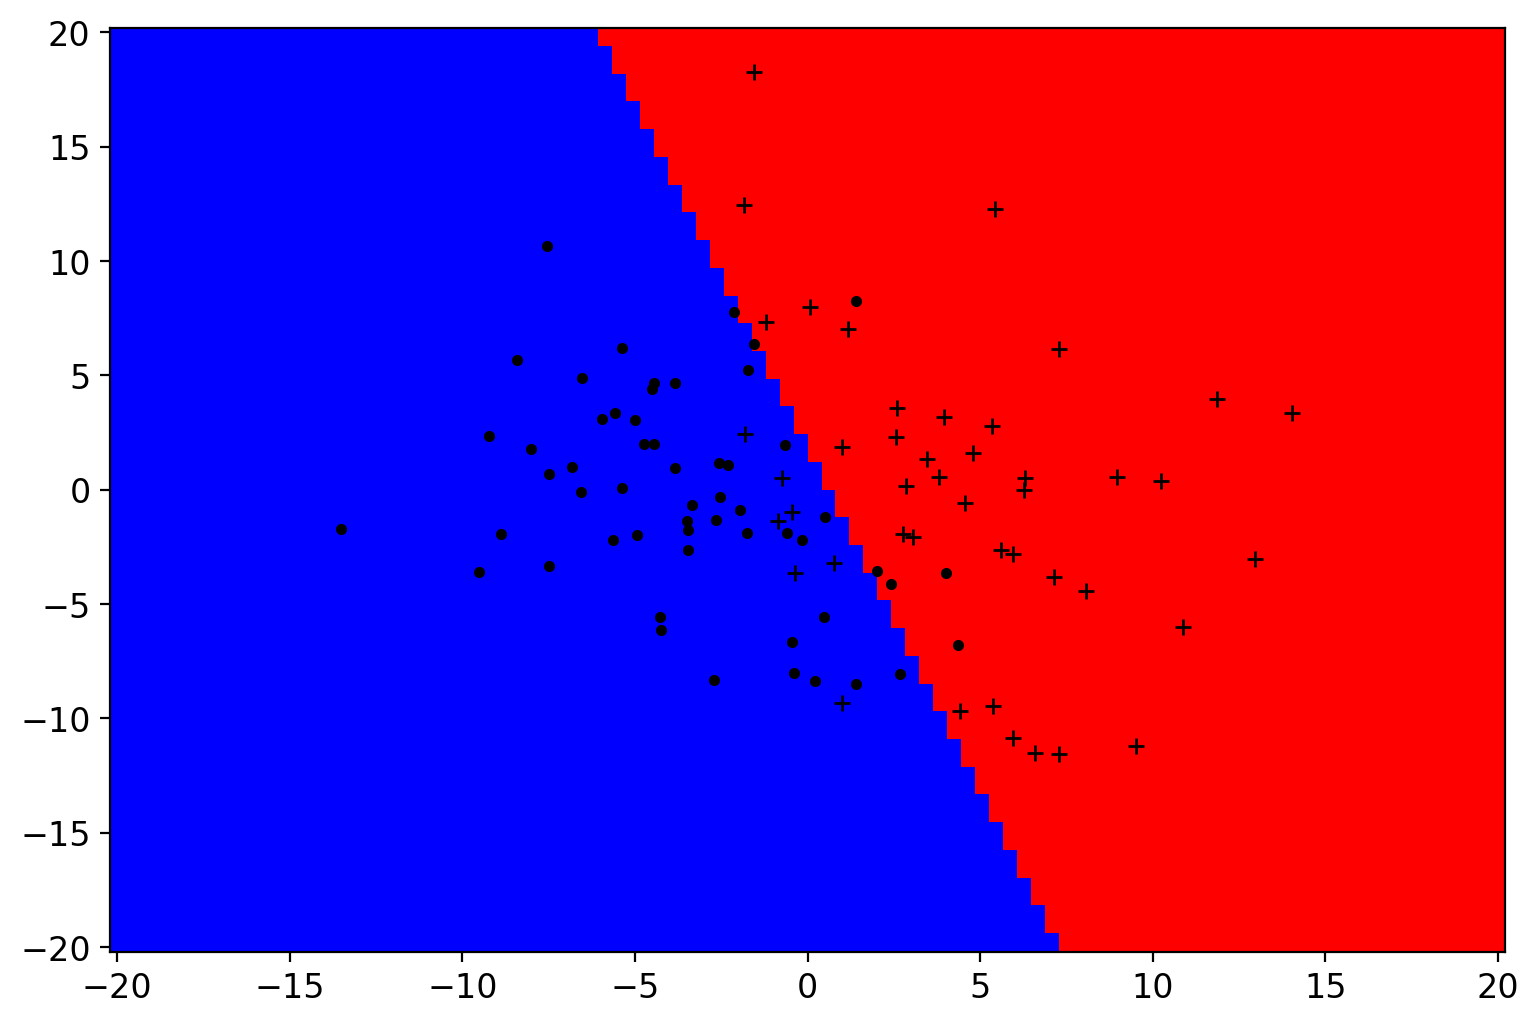

In [39]:
#create grid
x1_list = np.linspace(-20., 20., 100)
x2_list = np.linspace(-20., 20., 100)
x1_grid, x2_grid  = np.meshgrid(x1_list, x2_list)

#fill with model value
h_grid = np.sign(3.*x1_grid + x2_grid - 2. )

#draw 2d mesh
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.1.1</span>

Compute the loss for a slope of 2 to 4 on the slope and -2 to -4 in constant? Do you still see the same loss? What is the minimum. 


In [11]:
print(perceptron_loss(x_list,y_list,[3.0,1.],-3.))
print(perceptron_loss(x_list,y_list,[3.0,1.],-2.))
print(perceptron_loss(x_list,y_list,[3.0,1.],-4.))
####
print(perceptron_loss(x_list,y_list,[2.0,1.],-2.))
print(perceptron_loss(x_list,y_list,[3.0,1.],-2.))
print(perceptron_loss(x_list,y_list,[4.0,1.],-2.))

2.0
0.0
4.0
8.0
0.0
1.0


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
See code above
</pre>
        
**EXPLANATION:**
    
We see large variation when varying the slope vs varying the constant, this is consistent with our dataset, which has a near vertical slope.   
</div>

<a name='section_12_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.2 Support Vector Machine </h2>  



Now that we have done a very basic discrimination with a perceptron algorithm, we realize this guy is not the most useful setup since it gives us a discret classification of what is good and what is bad. As a consequence, to really go further, we need to avoid the discretization and make a classifer that carries some notion of distance away from the line. The simplest way to do this is with something called a support vector machine. 

We can write this as: 

$$
f(x|w,b) = w^{T}\vec{x}+b
$$

Now because this is a distance, we need to define a loss function, which since we now have a notion of distance, we define it such that for the a point on the line, the positive side of the line is correct and negative is not, which we will define as 1 if its at the line (0 distance), or in other words. 

$$
\textrm{max}[0,1-y_i f(x_i|w,b)],  y_i\in{-1,+1}$
$$

#### Ex. 2 : Support Vector Machine


Similar to perceptron algorithm, modify loss to select maximally discriminant parameters:

Linear model: $f(x|w,b) = w^{T}x+b$

Classifier: $\textrm{sign}(f(x|w,b))$

Loss: $L_i = \textrm{max}[0,1-y_i f(x_i|w,b)]$,  $y_i\in{-1,+1}$


In [12]:
def svm_loss(x,y,w,b):
    loss = 0.
    for i in range(len(x[0])):
        fm = x[0][i]*w[0]+x[1][i]*w[1]+b
        loss = loss + max(0.,1.-1.*y[i]*fm)
    return loss

print("SVM loss (w1=3, w2=1, b=-2)")
print(svm_loss(x_list,y_list,[3.,1.],-2.))
print("SVM loss (w1=3, w2=1, b=-1.6)")
print(svm_loss(x_list,y_list,[3.,1.],-1.6))
print("SVM loss (w1=3, w2=1, b=-2.4)")
print(svm_loss(x_list,y_list,[3.,1.],-2.4))

SVM loss (w1=3, w2=1, b=-2)
2.056434365059712
SVM loss (w1=3, w2=1, b=-1.6)
2.6084540256256292
SVM loss (w1=3, w2=1, b=-2.4)
2.207711999195955


Now, we can see above that when we are close to the line and moving around it, our values for the loss start to change, this avoids the discrete issue we had above.  

Let's go ahead and visualize it. 

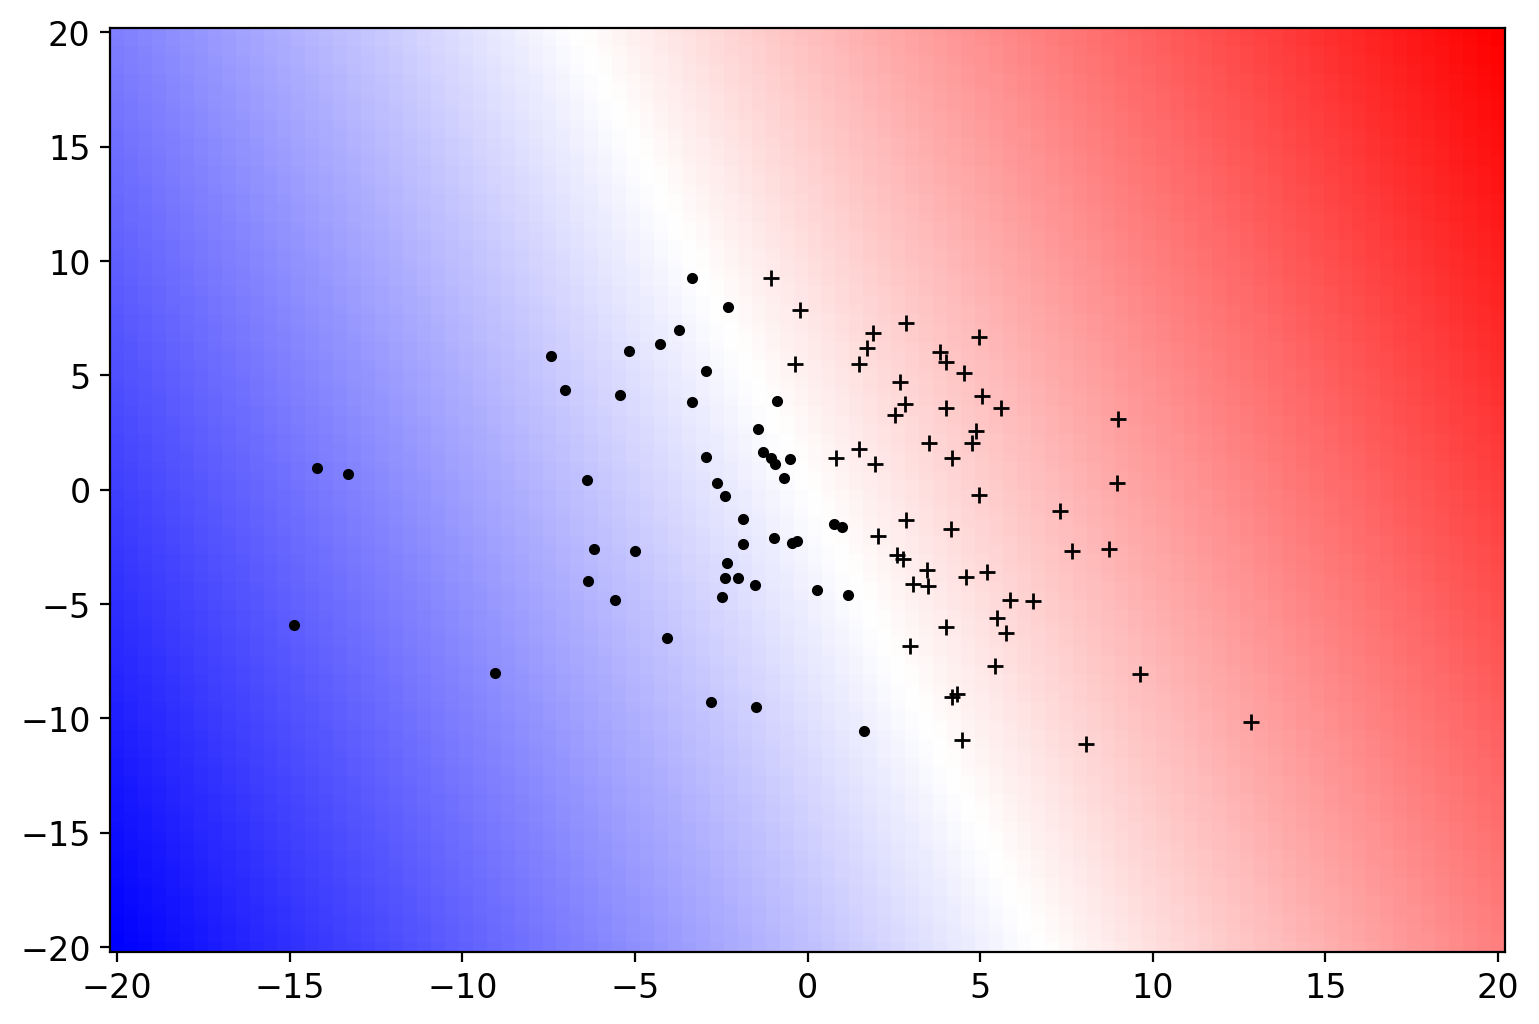

In [13]:
#create grid
x1_list = np.linspace(-20., 20., 100)
x2_list = np.linspace(-20., 20., 100)
x1_grid, x2_grid  = np.meshgrid(x1_list, x2_list)

#fill with model value
h_grid = (3.*x1_grid  + x2_grid - 2.)

#draw 2d mesh
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

Better... but what we really want is a probabilistic model. For data points we haven't seen, and more complex data, we want the algorithm to produce its confidence in the prediction.



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.2.1</span>

Lets say in the above distribution, we have a point that is at 100,100 how does this change the svm loss if it is incorrect/correct? 

In [17]:
x_list_tmp=np.array([[100],[100]])
y_list_tmp=np.array([1])
print(svm_loss(x_list_tmp,y_list_tmp,[3.,1.],-2.))

y_list_tmp=np.array([-1])
print(svm_loss(x_list_tmp,y_list_tmp,[3.,1.],-2.))


0.0
399.0


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
We get a 0 for correct 399 for incorrect
</pre>
        
**EXPLANATION:**
One incorrect point that is far away from the line can destroy the overall slope of the system. With simple data like above, this might be ok, but this could be very dangerous if we have one giant outlier. 
    
</div>

<a name='section_12_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.3 Logistic Regression </h2>  


Now given the above exercise, it starts to become clear that we want to do something that peaks at +/- 1 even if we are far away, that way we don't have one outlier spoiling our whole optimization process. In light of this, lets define a new function that tries to capture discrimination in terms of probability. 

$$
f(x|w,b)=\frac{1}{1+e^{-(w^{T}\vec{x}+b)}}
$$
When $x\rightarrow-\infty$ we have $0$, and when $x\rightarrow\infty$ we have $1$. This is, thus nicely bounded and gives us the opportunity to write down a loss that we can minimize. For this scenario, instead of labelling blue and red as $\pm$1 what we will do is label red as $1$ and blue as $0$. A loss with label 1 will give us the funtion $f(x|w,b)$ that we will want to set close to 1. A loss with label 0, will give us the same thing if we take $1-f(x|w,b)$. 

Now we can go one step further, and recall that from statistical mechanics that the Gibb's entropy, which we can write with Boltzmann's constant as: 

$$
S_{G} = k_{B} \sum_{i} p_{i} \log (p_{i})
$$

where we have given $n$ states with probability $p_{i}$ for each state, the above defines the $\log$ of the number of allowed states following the entropy definition.  

We can do the same thing for machine learning by considering two probablities $p$ and $q$. We want these probabilitis to match as close as possible, or in other words we want to maximize the number of states that are correct, and minimize the number of states that are incorrect. We can write this in terms of a likelihood as

$$
\mathcal{L}(\theta) = \prod_{i} ({\rm Estimated probability of occurence})^{\rm number of occurence} \\
\mathcal{L}(\theta) = \prod_{i} (q_{i})^{N p_{i}} \\
\log(\mathcal{L}(\theta)) = N \sum_{i} p_{i} \log(q_{i})
$$


and define the cross entropy noting the "estimated" probability is $q_{i}$ for an i-th instance, with the chances of this happening given by the N "empirical" probability $N p_{i}$ where $p_{i}$ is this emperical probability. Effectively, this is playing off our best fit function $f$ against the observed data $p$ and $N$.

For this scenario, our observed probability is its red $1$ or blue $0$, which is just the truth label, or in this case $y_{i}=[0,1]$ for blue and red respectively. Likewise, we can make the predicted probability $q_{i}(\theta)=f(x|w,b)$ this is for one scneario (blue). The cross entropy then can be written 

$$
\log(\mathcal{L_{\rm red}}(\theta))  = \sum_{i} y_{i} \log(f(x_i|w,b)) \\
\log(\mathcal{L_{\rm blue}}(\theta)) = \sum_{i} (1-y_{i}) \log(1-f(x_i|w,b)) \\
NLL_{i} = -\log(\mathcal{L_{\rm red}}(\theta))  - \log(\mathcal{L_{\rm blue}}(\theta))
$$

In otherwords, we sum over both samples of red and blue and aim to maximize the probability that our system is correct. 

Let's go ahead and run over the regression and see how it looks. 

#### Ex. 3 : Logistic regression

Change from \[-1,1\] to \[0,1\] for simplicity

Model: $f(x|w,b)=\frac{1}{1+e^{-(w^{T}x+b)}}$

Loss: $L_i = -y_i \log(f(x_i|w,b)) - (1-y_i)\log(1-f(x_i|w,b))$
    (known as *Binary Cross Entropy*)

In [40]:
#switch to [0,1] from [-1,1]

y_list_0 = [1.]*len(x1_pos) + [0.]*len(x1_neg)

def lr_loss(x,y,w,b,scale=1.):
    loss = 0.
    for i in range(len(x[0])):
        expon = -1.*scale*(x[0][i]*w[0]+x[1][i]*w[1]+b)
        if (expon > 99.):
            expon = 99.
        fm = 1./(1.+np.exp(expon))
        if (fm < 1. and fm > 0.):
            loss = loss - y[i]*np.log(fm) - (1.-y[i])*np.log(1.-fm)
    return loss

print("Logistic regression loss (w1=3, w2=1, b=-2) [scale = 1]")
print(lr_loss(x_list,y_list_0,[3.,1.],-2.))
print("Logistic regression loss (w1=3, w2=1, b=-1.9) [scale = 1]")
print(lr_loss(x_list,y_list_0,[3.,1.],-1.9))
print("Logistic regression loss (w1=3, w2=1, b=-2.1) [scale = 1]")
print(lr_loss(x_list,y_list_0,[4.,1.],-2.1))
print("")
print("Logistic regression loss (w1=3, w2=1, b=-2) [scale = 1.5]")
print(lr_loss(x_list,y_list_0,[3.,1.],-2.,1.5))
print("Logistic regression loss (w1=3, w2=1, b=-2) [scale = 0.5]")
print(lr_loss(x_list,y_list_0,[3.,1.],-2,0.5))

Logistic regression loss (w1=3, w2=1, b=-2) [scale = 1]
131.26960406832885
Logistic regression loss (w1=3, w2=1, b=-1.9) [scale = 1]
132.15913609200862
Logistic regression loss (w1=3, w2=1, b=-2.1) [scale = 1]
140.7492428671686

Logistic regression loss (w1=3, w2=1, b=-2) [scale = 1.5]
154.11534767465386
Logistic regression loss (w1=3, w2=1, b=-2) [scale = 0.5]
71.96690359917667


You will notice above, we added an additional "Scale term", the scale term changes the impact of the slope on the expontential. What htis means is : 

 * A large scale will increase confidence
 * A small scale will decrease the confidence of discrimination
 
Let's visualize this below: 

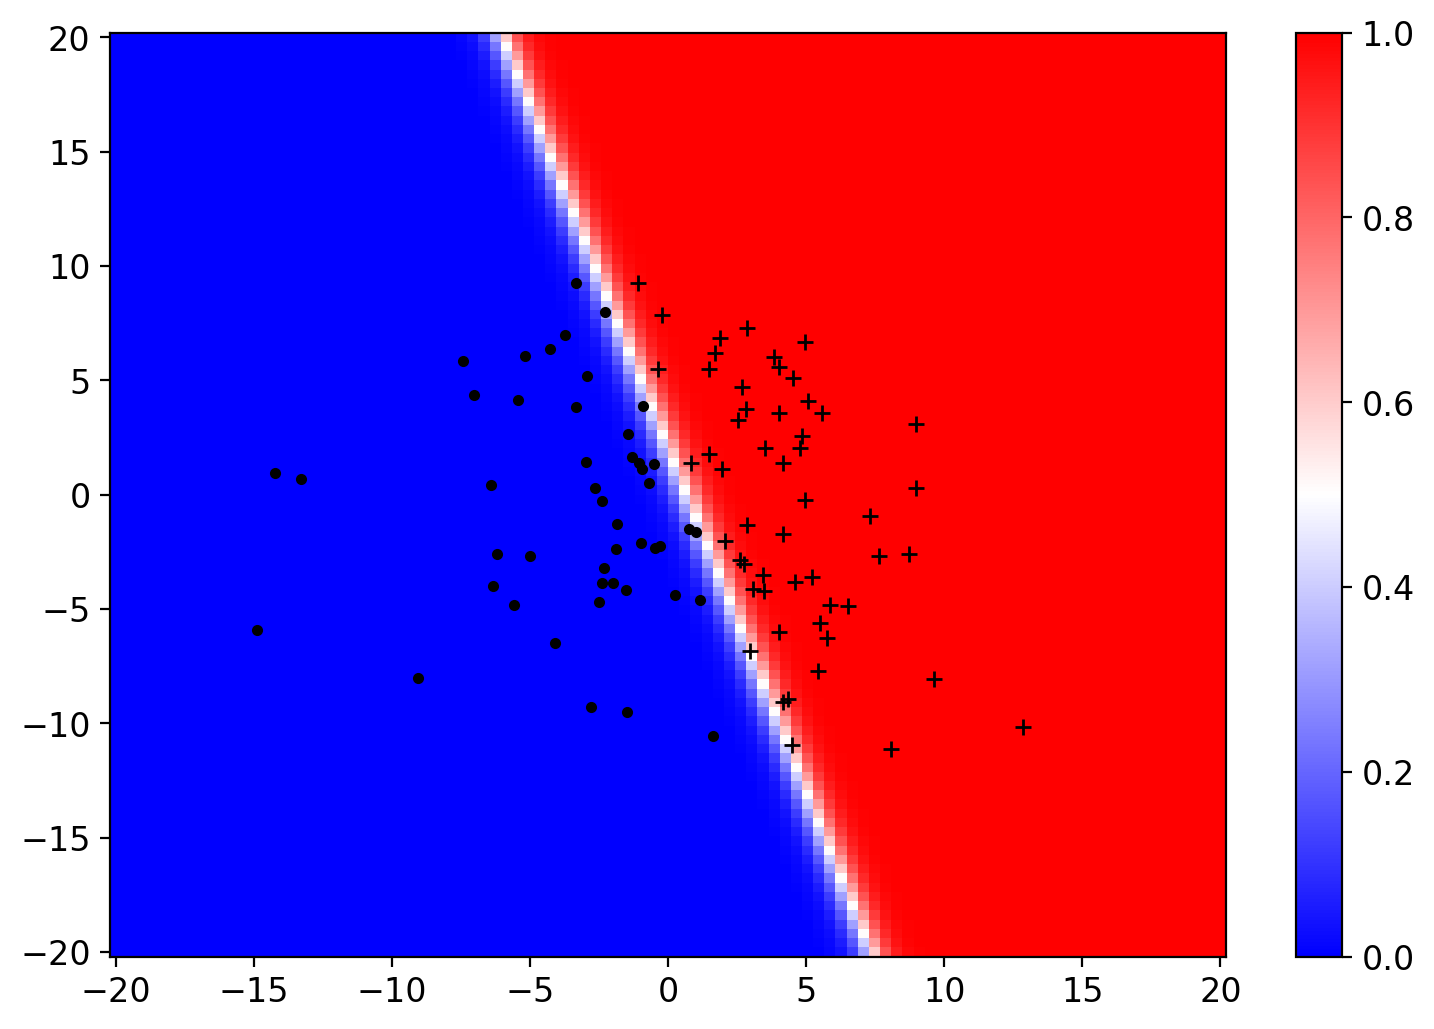

In [33]:
#fill with model value
h_grid = 1./(1.+np.exp(-1.*1.0*(3*x1_grid + x2_grid - 2)))

#draw 2d mesh
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

This is a neural network! No hidden layers, two inputs, one output neuron with a sigmoid activation.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.3.1</span>

Take the above plot, and modify the scale parameter from its current value to 100 large and 100 times smaller. How does this impact that value at -20,-20? 

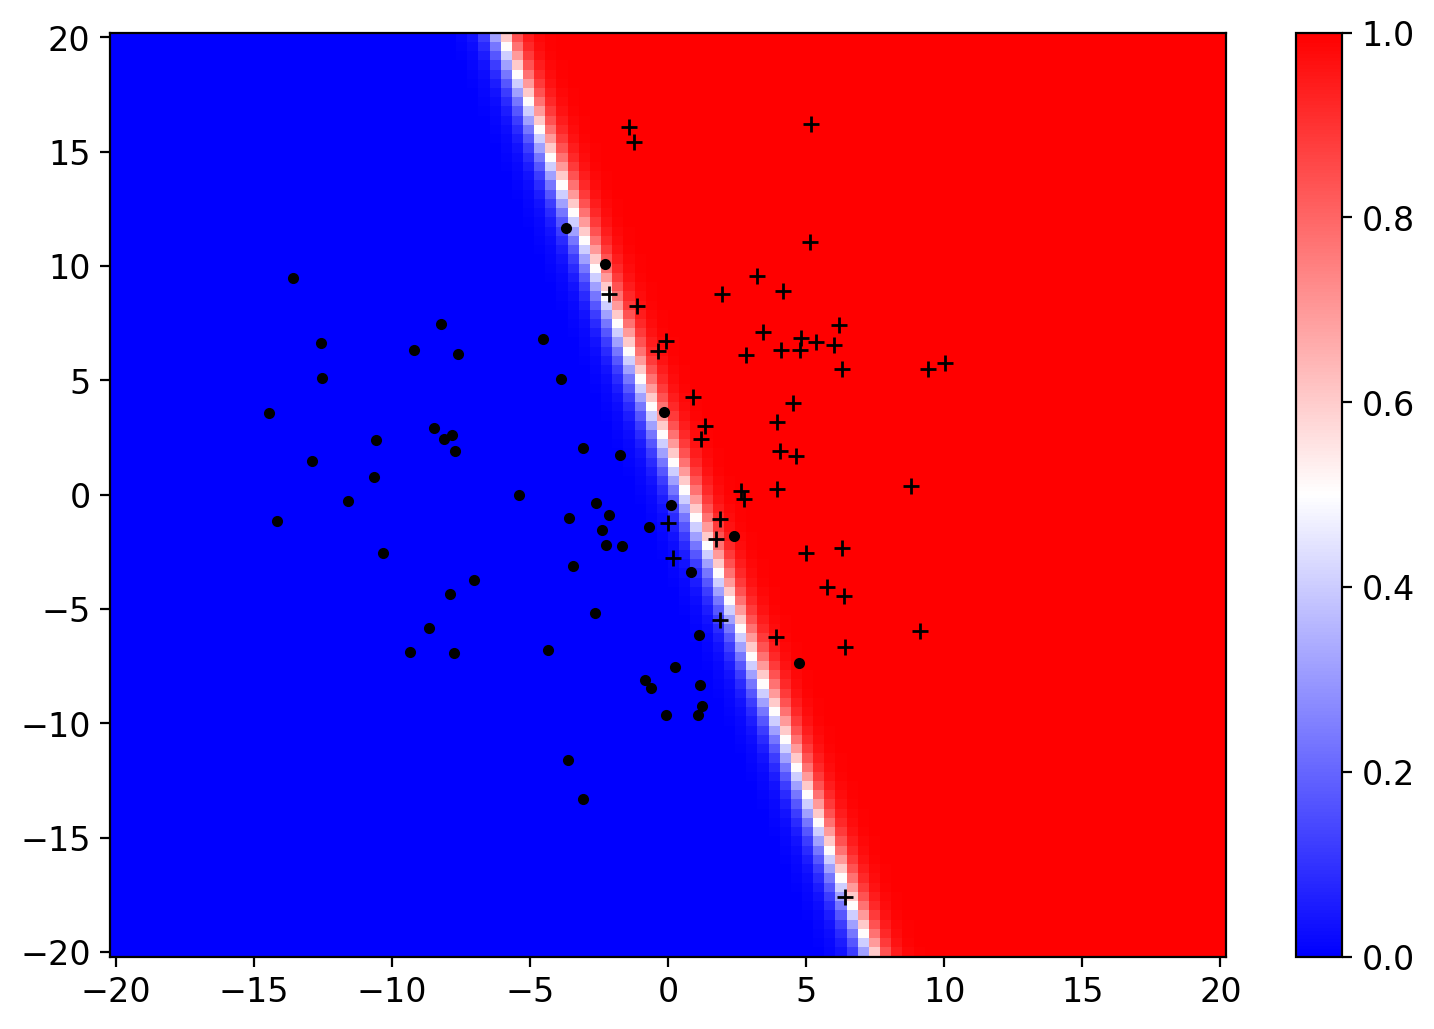

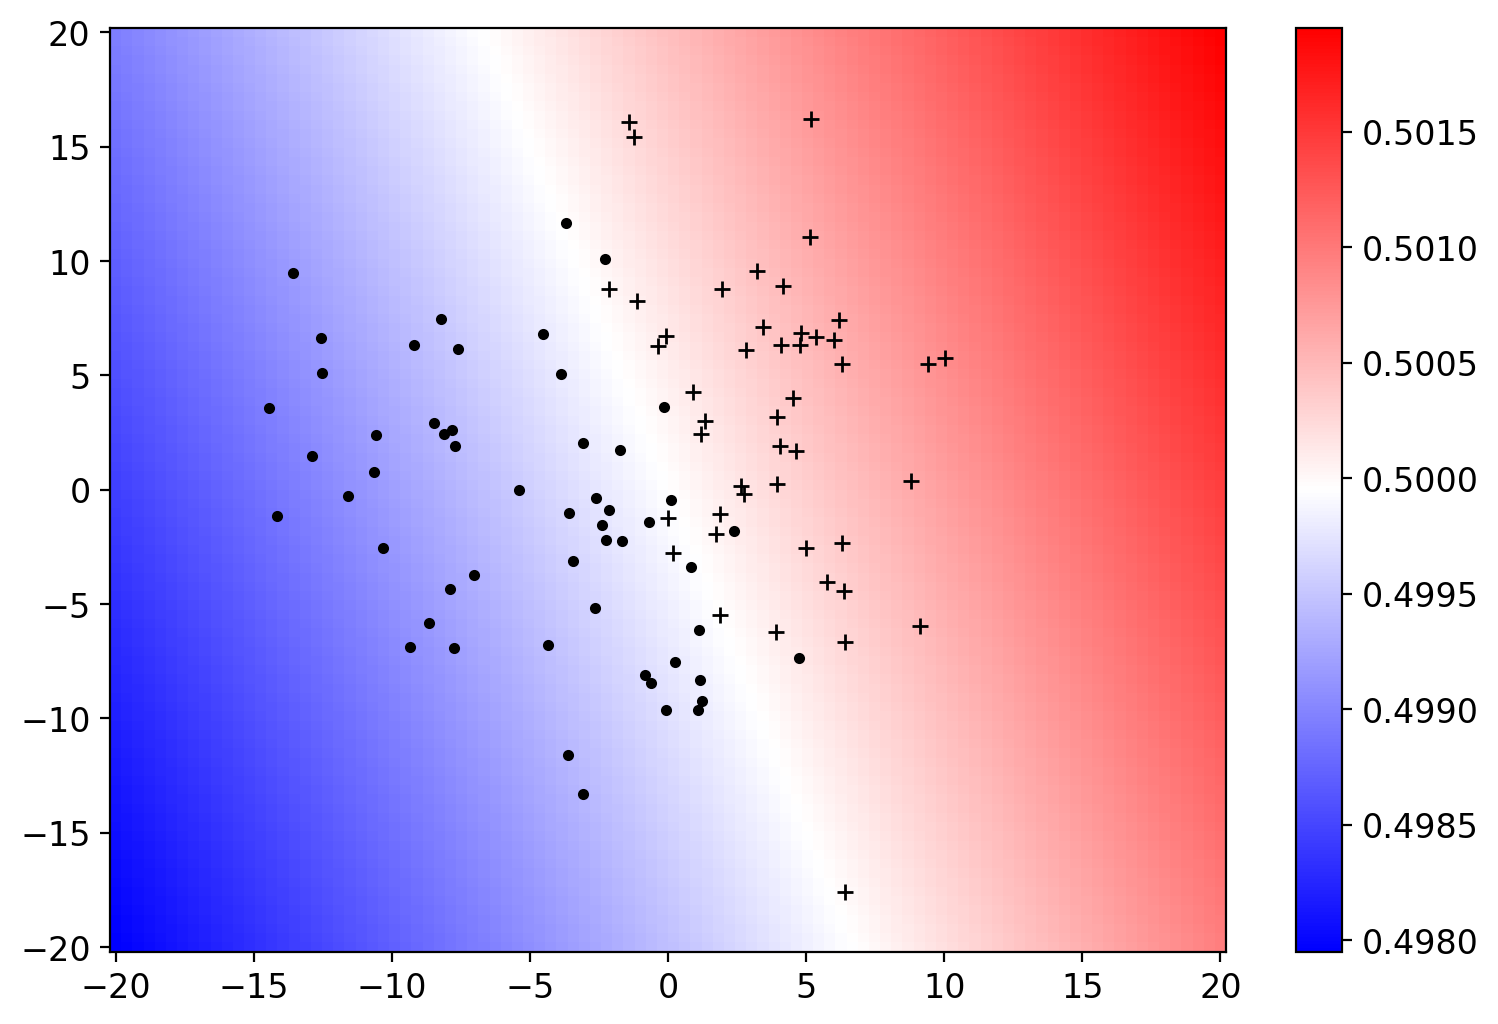

In [93]:
#fill with model value
h_grid = 1./(1.+np.exp(-1.*(x2_grid - (2. - 3.*x1_grid))))

#draw 2d mesh
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

#fill with model value
h_grid = 1./(1.+np.exp(-1.*0.0001*(x2_grid - (2. - 3.*x1_grid))))

#draw 2d mesh
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
[0 => 2 up,0.498 => 2 down]
</pre>
        
**EXPLANATION:**
Look at the z-axis here, you can see it dramatically varies. If we interpret the z-axis as a value of the confidence, you observe right away that this dramatically changes the way we interpret our data. 
    
</div>

<a name='section_12_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.4 Training a Neural Network</h2>  


Now the above is a neural network what with an output from 0 to 1. The output function is what we call a sigmoid. The matrix multiply of the inputs is what we call the input layer. Thats it! 

We can build networks easily, here is a fun tool to build your own neural networks. Have a go!

https://playground.tensorflow.org/

How do we train? How do we handle more complicated data?

Before we go into real training of our netowork, lets just treat our neural network as if we were to run a fit. On top of what we did above, lets just run a minimizer tool and minimize our loss.

What we can do is take our loss above, and solve for the best fit parameters using all the minimizer tools that we have been using in class! 

This process is what we call **Training** a neural network. 

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 42.251492198654425
        x: [ 1.440e+00  3.322e-01 -2.571e+00  3.526e-01]
      nit: 14
      jac: [ 7.153e-06  4.768e-07  6.199e-06  4.292e-06]
 hess_inv: [[ 1.792e-02  1.174e-02 -9.186e-02 -7.672e-03]
            [ 1.174e-02  2.666e-02 -2.725e-02 -3.557e-03]
            [-9.186e-02 -2.725e-02  8.601e-01  2.982e-02]
            [-7.672e-03 -3.557e-03  2.982e-02  7.628e-03]]
     nfev: 80
     njev: 16


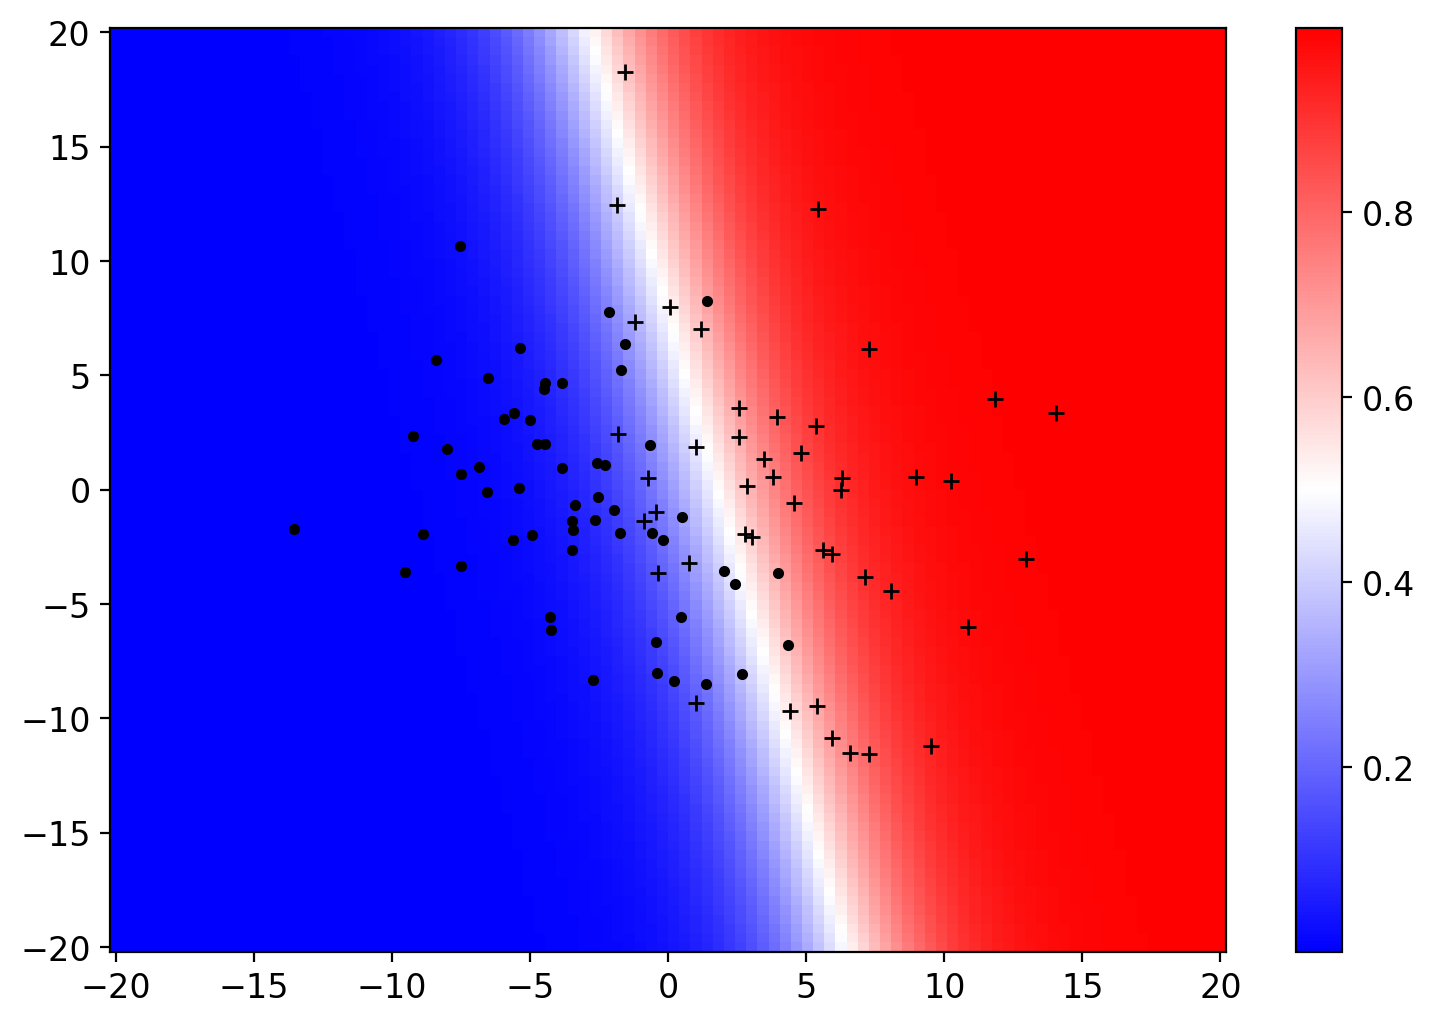

Scaled Pars: 1.1203556080734671 0.258476096279968


In [41]:
x0 = np.array([0,0,0,1.])
#def lr_loss(x,y,w,b,scale=1.):
def fun(inputs):
  loss=lr_loss(x_list,y_list_0,[inputs[0],inputs[1]],inputs[2],inputs[3])
  return loss

sol=opt.minimize(fun,x0)
print(sol)

#Now plot it
h_grid = 1./(1.+np.exp(-1.*sol.x[3]*(sol.x[0]*x1_grid+sol.x[1]*x2_grid + sol.x[2] )))
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

print("Scaled Pars:",sol.x[0]*(-2./sol.x[2]),sol.x[1]*(-2./sol.x[2]))

Notice, that we also floated our scale parameter above. We did this because we can. You can see that out of this we get a notion of how confident we are about our fit and our data. 

One other thing that we can also do with our minimizer is look at the uncertainties on our parameters. This is actually something, we traditionally don't do with neural networks. The reason being that we will quickly make the networks very complicated with a lot of parameters. This makes it hard to compute the hessian (it takes $\mathcal{O}(N^{2})$ derivative comptutations where $N$ is the number of variables. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.4.1</span>

What happens to the best fit parameters when you force the scale to be 1?  

In [35]:
x0 = np.array([0,0,0])
#def lr_loss(x,y,w,b,scale=1.):
def fun(inputs):
  loss=lr_loss(x_list,y_list_0,[inputs[0],inputs[1]],inputs[2],scale=1.0)
  return loss

sol=opt.minimize(fun,x0)
print(sol)

print("Scaled Pars:",sol.x[0]*(-2./sol.x[2]),sol.x[1]*(-2./sol.x[2]))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.5366005503665022e-06
        x: [ 6.052e+01  1.729e+01 -4.782e+01]
      nit: 31
      jac: [-3.770e-06  8.792e-06 -1.147e-06]
 hess_inv: [[ 4.739e+06  1.359e+06 -3.776e+06]
            [ 1.359e+06  3.898e+05 -1.083e+06]
            [-3.776e+06 -1.083e+06  3.009e+06]]
     nfev: 136
     njev: 34
Scaled Pars: 2.5310810929548557 0.7233220582455061


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
1=>1.25,0.3=>0.37,-0.5=>-0.61

Rescaled Parameters are the same
</pre>
        
**EXPLANATION:**
Some care is needed to interpret these parameters. Since we are concerned about the formula

$$
w_{1} x_{1} + w_{2} x_{2} + b > 0
$$

we need to ensure the relative weights lead to an interpretable dataset, that means we need to scale things to be able to compare the results with the past. Scaling so that $b=2$ we have: 
    
    * $w_{1}$ 4.1 => 4.1
    * $w_{2}$ 1.2 => 1.2
    
Or in fact our results are exactly the same, the scale doesn't change our best fit at all 
</div>

<a name='section_12_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.5 Training a Neural Network with Pytorch</h2>  


What we did was just fitting a function, but this effectively all we are doing when we are training a neural network. Let's go ahead and do the **exact same thing**, but now with the neural network. In this case, we will use pytorch. If you would like to see how to do this in another framework see the other notebook, which uses Keras/tensorflow. Keras is another machine learning framework built on the tensorflow machine learning framework. Both Keras and Pytorch are commonly used frameworks. We use pytorch, for slight personal preference. 

Now, we can finally go ahead and train our neural network. From that, we will now finally pull in pytorch. There are many ways to do this, but here we will focus on the pytorch approach to building a deep learning algorithm. 

The first step is to declare the network. We will label this as an "MLP" or multilayer perceptron. That is the technical definition of this network. Let's creat it, and just print out the parameters. 

In [42]:
#now lets do this with a neural network

class simple_MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return x
    

simple_model = simple_MLP()
print(simple_model.named_parameters('fcl'))
print('----------')
print(simple_model.state_dict())

<generator object Module.named_parameters at 0x7f807e1ab140>
----------
OrderedDict([('fc1.weight', tensor([[ 0.3164, -0.0607]])), ('fc1.bias', tensor([0.4628]))])


Now, we have created the model and we can see what it is doing. This model is just the same as before, but now we have put into pytorch that enables us to use all sorts of bells and whistles going forward within the pytorch framework, which has a whole slew of deep learning. 

The first thing we will do with this network is "train it", this just means fitting it. Except now we fit with a simplified minimizer that actually doesn't compute Hessian's. This makes it a lot faster. It also does less sophisticaed step calculations, which also makes it mroe robust. 

The last thing is that we don't necessarily tell the minimizer when to stop, we just let it go for a while and then we take the best fitted value. I know this is all seems a littel weird compared to fitting, but there is nothing special to this. 

[1] loss: 0.3820  
[2] loss: 0.3704  
[3] loss: 0.3593  
[4] loss: 0.3489  
[5] loss: 0.3390  
[6] loss: 0.3296  
[7] loss: 0.3208  
[8] loss: 0.3125  
[9] loss: 0.3048  
[10] loss: 0.2975  
[11] loss: 0.2906  
[12] loss: 0.2842  
[13] loss: 0.2782  
[14] loss: 0.2725  
[15] loss: 0.2672  
[16] loss: 0.2621  
[17] loss: 0.2574  
[18] loss: 0.2529  
[19] loss: 0.2486  
[20] loss: 0.2445  
[21] loss: 0.2406  
[22] loss: 0.2368  
[23] loss: 0.2332  
[24] loss: 0.2297  
[25] loss: 0.2263  
[26] loss: 0.2230  
[27] loss: 0.2198  
[28] loss: 0.2167  
[29] loss: 0.2136  
[30] loss: 0.2107  
[31] loss: 0.2078  
[32] loss: 0.2050  
[33] loss: 0.2023  
[34] loss: 0.1996  
[35] loss: 0.1971  
[36] loss: 0.1946  
[37] loss: 0.1922  
[38] loss: 0.1899  
[39] loss: 0.1876  
[40] loss: 0.1854  
[41] loss: 0.1833  
[42] loss: 0.1812  
[43] loss: 0.1793  
[44] loss: 0.1773  
[45] loss: 0.1755  
[46] loss: 0.1736  
[47] loss: 0.1719  
[48] loss: 0.1701  
[49] loss: 0.1685  
[50] loss: 0.1668  
[51] loss

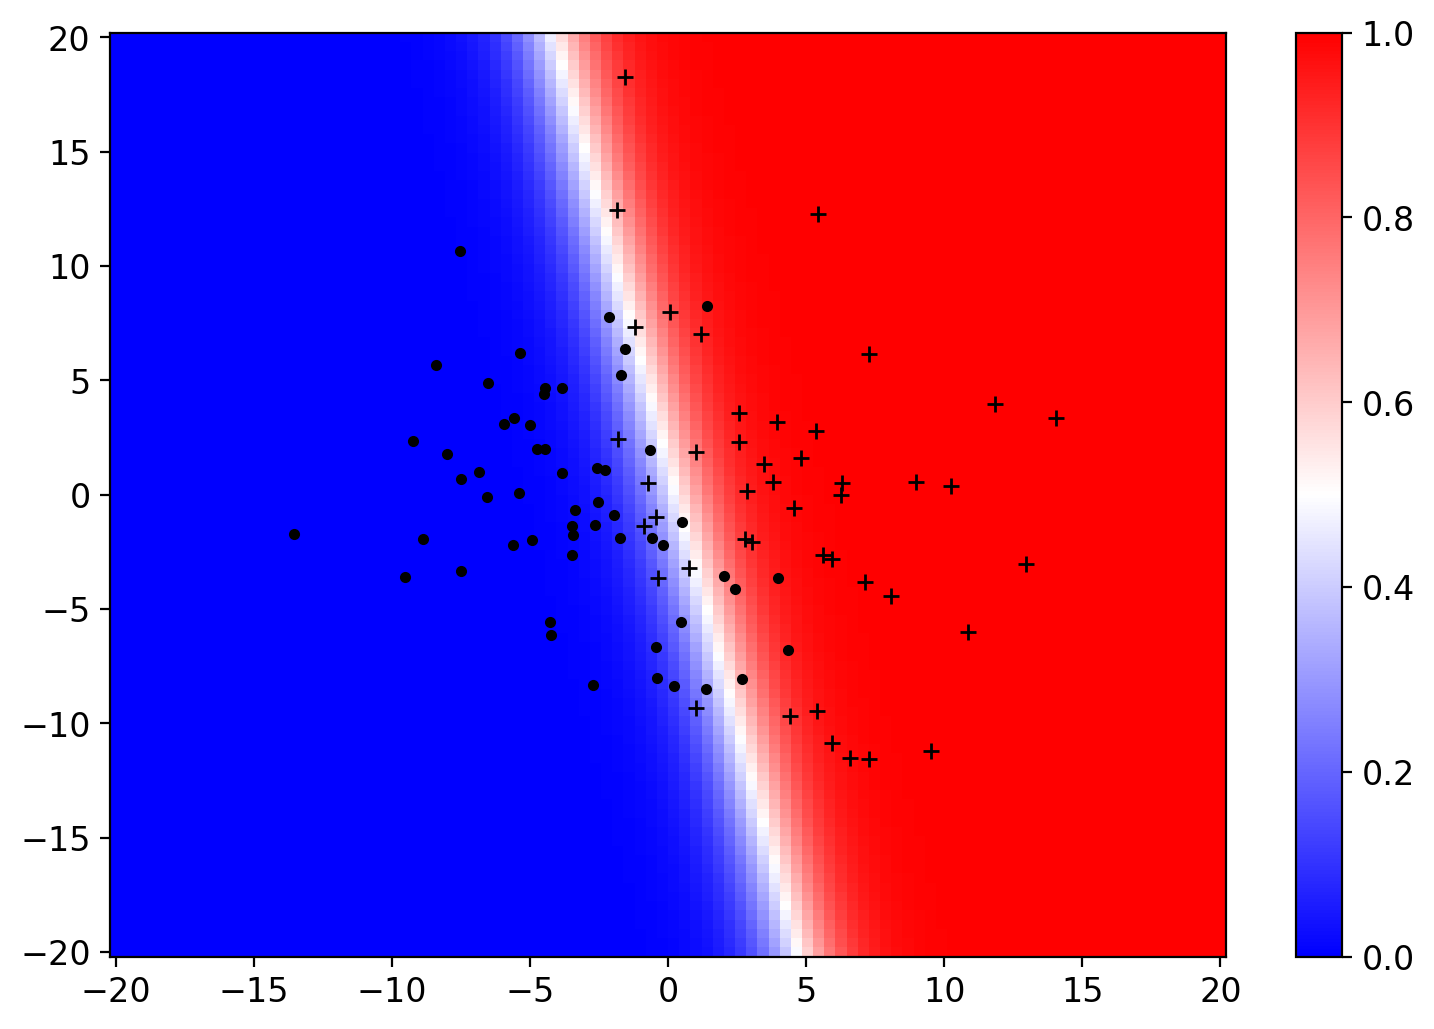

OrderedDict([('fc1.weight', tensor([[1.0127, 0.2226]])), ('fc1.bias', tensor([-0.2931]))])


In [43]:
#Create a loss and minimizer 
simple_criterion = torch.nn.BCELoss() #BCE => Binary Cross Entropy
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
simple_history = {'loss':[]}

#pytorch
x_list_np = np.transpose(np.vstack((x_list[0],x_list[1])))
y_list_np = (np.array(y_list)+1)/2
x_torch=torch.from_numpy(x_list_np).float()
y_torch=torch.from_numpy(y_list_np.reshape(100,1)).float()

for epoch in range(100):
    simple_optimizer.zero_grad()
    outputs = simple_model(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
    simple_history['loss'].append(current_loss)
            
print('Finished Training')
torch.save(simple_model.state_dict(), 'simple_model.pt')
print(simple_model.state_dict())

#Now plot it
x_grid_np = np.transpose(np.vstack((x1_grid.flatten(),x2_grid.flatten())))
x_torch=torch.from_numpy(x_grid_np).float()
h_grid = simple_model(x_torch)
h_grid=h_grid.detach().numpy()
h_grid=h_grid.reshape(100,100)
print(h_grid.shape)
plt.pcolormesh(x1_grid, x2_grid, h_grid, cmap = 'bwr', shading='auto')
plt.colorbar()

plt.plot(x1_pos, x2_pos, 'k+')
plt.plot(x1_neg, x2_neg, 'k.')

plt.show()

print(simple_model.state_dict())

That's it, we have now used pytorch to classify points. Points are not the greatest things to classify. We can often classify much more complicated things and use this for all sorts of interesting physics problems. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.5.1</span>

What are the best fit parameters of the neural network. How do they compare to our minimizer? (Note: be sure to scale these parameters following 12.4.1)

In [44]:
print(simple_model.fc1.weight[0][0]*(2/simple_model.fc1.bias[0]),simple_model.fc1.weight[0][1]*(2/simple_model.fc1.bias[0]))

tensor(-6.9108, grad_fn=<MulBackward0>) tensor(-1.5188, grad_fn=<MulBackward0>)


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
4.1=>4.1,1.2=>1.2
Rescaled Parameters are the same
</pre>
        
**EXPLANATION:**
This is not a surprise, if our minimizer is actually minimizing we end up with the same best fit parameters. 
</div>

<a name='section_12_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.6 A more realistic deep learning example </h2>  


Now, that we have trained a very simple network. Let's go ahead and take a real physics dataset and train an nueral network. For this, what we are going to do is train a neural network that does photon identification at the Large Hadron Collider.  In particular, we will construct a discriminator that outputs the probability that a particle that we reconstructed was a photon or a "fake" photon. A fake photon in this case is typically a pion. A pion is particle consisting of two quarks. Pions can decays to a pair of photons that are so close such that the photons merge into a single photon and look like a photon Other things that can look like a photon are charged pions and electrons. Photon identification is an important problem and it is what we used to identify good photons that led to the Higgs boson discovery. We regularly update our photon id and try to improve, the photon id has used some sort of either deep learning or machine learning for the last 10 years at the LHC. Suffice it to say that this is an excellent machine learning problem. 

To separate photons from background, we will compute large nmber of different variables that allow us to do these descriminations. These variables are all based on the moments and enegies of the nearby electromagnetic cluster, and reconstructed particles in the collision. 

One last thing is that we will use pandas dataframes to process this. Pandas is one of the standard python data formats that is quite popular for machine learning. Let's go ahead and look at what we get!


In [5]:
import h5py

filename = 'data/xtalTuple_TTbar_PU0.z'

treename = 'l1pf_egm_reg'

VARS = ['pt', 'eta', 'phi', 'energy',
  'e2x2', 'e2x5', 'e3x5', 'e5x5', 'e2x2_div_e2x5', 'e2x2_div_e5x5', 'e2x5_div_e5x5',#7
  'hoE', 'bremStrength', 'ecalIso', 'crystalCount',#4
  'lowerSideLobePt','upperSideLobePt',#2
  'phiStripContiguous0', 'phiStripOneHole0', 'phiStripContiguous3p', 'phiStripOneHole3p',#4
  'sihih','sipip','sigetaeta','sigphiphi','sigetaphi',#5
  'e_m2_m2','e_m2_m1','e_m2_p0','e_m2_p1','e_m2_p2',
  'e_m1_m2','e_m1_m1','e_m1_p0','e_m1_p1','e_m1_p2',
  'e_p0_m2','e_p0_m1','e_p0_p0','e_p0_p1','e_p0_p2',
  'e_p1_m2','e_p1_m1','e_p1_p0','e_p1_p1','e_p1_p2',
  'e_p2_m2','e_p2_m1','e_p2_p0','e_p2_p1','e_p2_p2',#^25
  'h_m1_m1','h_m1_p0','h_m1_p1',
  'h_p0_m1','h_p0_p0','h_p0_p1',
  'h_p1_m1','h_p1_p0','h_p1_p1',#^9
  'gen_match']

#rad and pring it
h5file = h5py.File(filename, 'r') # open read-only
params = h5file[treename][()]

df = pd.DataFrame(params,columns=VARS)

TODROP = [
  'e2x2_div_e2x5', 'e2x2_div_e5x5', 'e2x5_div_e5x5',#7
  'e_m2_m2','e_m2_m1','e_m2_p0','e_m2_p1','e_m2_p2',
  'e_m1_m2','e_m1_m1','e_m1_p0','e_m1_p1','e_m1_p2',
  'e_p0_m2','e_p0_m1','e_p0_p0','e_p0_p1','e_p0_p2',
  'e_p1_m2','e_p1_m1','e_p1_p0','e_p1_p1','e_p1_p2',
  'e_p2_m2','e_p2_m1','e_p2_p0','e_p2_p1','e_p2_p2',#^25
  'h_m1_m1','h_m1_p0','h_m1_p1',
  'h_p0_m1','h_p0_p0','h_p0_p1',
  'h_p1_m1','h_p1_p0','h_p1_p1',#^9
]

df = df.drop(TODROP, axis=1) #remove custom variables

#normalize the shower shapes by energy
for ie in ['e2x2', 'e2x5', 'e3x5', 'e5x5']:
    df[ie] /= df['energy']

#add some labels
df['isPU'] = pd.Series(df['gen_match']==0, index=df.index, dtype='i4')
df['isEG'] = pd.Series(df['gen_match']==1, index=df.index, dtype='i4')

#now select the dataset based on their transverse momentum (pt)
MINPT = 0.5
MAXPT = 100.
df = df.loc[(df['pt']>MINPT) & (df['pt']<MAXPT) & (abs(df['eta'])<1.3)]
df.fillna(0., inplace=True)

#take a fixed nubmer of events
df0 = df[df['gen_match']==0].head(100000)
df1 = df[df['gen_match']==1].head(10000)

df = pd.concat([df0, df1], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

#Now lets check it all
print(df)
print(sum(df['gen_match']==0))
print(sum(df['gen_match']==1))


               pt       eta       phi     energy      e2x2      e2x5  \
0       43.861504  0.330484  1.275403  46.278653  0.633067  0.755808   
1       41.508152  0.291721  1.710212  43.286907  0.362185  0.564216   
2        8.653792  0.127139  0.299071   8.723829  0.476319  0.476319   
3       10.590255  0.416267 -1.719283  11.521111  0.731805  0.731805   
4       15.848024 -1.037736  1.799982  25.175187  0.503293  0.503293   
...           ...       ...       ...        ...       ...       ...   
109995  52.025410 -1.234589  2.652055  96.973290  0.420636  0.490142   
109996  12.170704 -0.012762 -2.070260  12.171695  0.657324  0.739487   
109997  11.856803  0.473824  0.380338  13.212873  0.737971  0.737971   
109998  12.794809 -0.556863  2.223550  14.830421  0.703701  0.742487   
109999  10.270598 -0.155868  2.510749  10.395613  0.438142  0.730237   

            e3x5      e5x5       hoE  bremStrength  ...  phiStripContiguous3p  \
0       0.854982  0.934800  2.115751      1.000000  ..

Given that we have the dataset, lets go ahead and plot everything. We can take the classic colors that red is signal and the blue is the background. Our goal in the end will be to use all of the variables that we have selected in the dataset to separate blue from red. This is a large multidimensional problem, and so you can see why it will be hard for us to just do this by hand cutting on parameters. 

Here, we really need to come up with an automated scheme, this is what pytorch helps us for. 

In [7]:
col_names = list(df.columns)

#fig, axs = plt.subplots(len(col_names),1,figsize=(8,100))
#for ix,ax in enumerate(axs):
#    ax.hist(df[col_names[ix]][df['gen_match']==0],bins=np.linspace(np.min(df[col_names[ix]]),np.max(df[col_names[ix]]),20),histtype='step',color='r',density=True)
#    ax.hist(df[col_names[ix]][df['gen_match']==1],bins=np.linspace(np.min(df[col_names[ix]]),np.max(df[col_names[ix]]),20),histtype='step',color='b',density=True)
#    ax.set_xlabel(col_names[ix])
#plt.show()

The other thing to remind ourselves is that many of these variables can be correlated. What that means is that when we select on one variable, we are potentially selecting on another. The network can recognize this and attempt to "Decorrelate" variables to get better performance. Sometimes its too good at this and makes our problem more difficult.  

Let's go ahead and make a correlation matrix plot of all of our input variables. We can see which correlations allow us to separate signal and backgrounds. 

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)

#medium_size = 12
#large_size = 15

medium_size = 6
large_size = 6

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

#plt.rcParams['figure.figsize'] = (8,8)
fig, axs = plt.subplots(len(col_names)-4,len(col_names)-4)#,figsize=(8*len(col_names),8*len(col_names)))
for ix in range(len(col_names)-3):
    for iy in range(ix):
        axs[ix-1,iy].plot(df[col_names[ix]][df['gen_match']==0],df[col_names[iy]][df['gen_match']==0],'r+')
        axs[ix-1,iy].plot(df[col_names[ix]][df['gen_match']==1],df[col_names[iy]][df['gen_match']==1],'b.')
        axs[ix-1,iy].set_xlabel(col_names[ix])
        axs[ix-1,iy].set_ylabel(col_names[iy])

plt.show()

plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


Lets make a simple logistic regression network on this data to differentiate between background data (labeled as PU) and electron and photons (EG).


An important component of training a neural network is preparing the input. It is typical to split the data you have into different sets. Three are common: "training", "testing", and "validation".
Here we use 30% of the data for testing and 70% for training and validation, with that data split 80%/20% for training/validation.
PyTorch uses `dataloaders` which help handle batching, etc.  The reason for each is: 

 * Training : This our datset that we use for to learn our process
 * Validation : This is a dataset that we use while training to check that our loss is the same or similar on independent data
 * Testing : This is the dataset that we use to compute the performance of the algorithm
 
Let's go ahead and make these datasets. It will be clear how we use them in a sec. 

In [11]:
dataset = df.values

X = dataset[:,4:-3]
print(X.shape,dataset.shape,col_names[4],col_names[22])
#last 3 columns are labels
ninputs = len(list(df.columns))-3-4

Y = dataset[:,-1:]
#last column will be used for the label

test_frac = 0.3
val_frac = 0.2

torch.random.manual_seed(42) # fix a random seed for reproducibility
alldataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

testdataset, trainvaldataset = torch.utils.data.random_split(
    alldataset, [int(len(Y)*test_frac),
              int(len(Y)*(1-test_frac))])

traindataset, valdataset = torch.utils.data.random_split(
    trainvaldataset, [int(len(Y)*(1.-test_frac)*(1.-val_frac)),
              int(len(Y)*(1.-test_frac)*val_frac)])

testloader = torch.utils.data.DataLoader(testdataset,
                                          num_workers=6,
                                          batch_size=500,
                                          shuffle=False)
trainloader = torch.utils.data.DataLoader(traindataset,
                                          num_workers=6,
                                          batch_size=500,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataset,
                                        num_workers=6,
                                        batch_size=500,
                                        shuffle=False)


(110000, 19) (110000, 26) e2x2 sigetaphi


Now we need to define our network architecture and the connections. Lets start with the kind of logistic regression network we saw already. This will be a 1-layer network. We will take in the number of inputs and then run our sigmoid function on the outputs, like we did above. 

PyTorch requires that we first define the layers we want to use in `__init__()` (here we build using standard library layers), and then we define the connection in `forward()`. This setup will allow PyTorch to construct the backward pass automatically, although for more complex or specialized networks it is possible to define the backward pass manually.

In [12]:
class LR_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return x
    

model_lr = LR_net()
print(model_lr)
print('----------')
print(model_lr.state_dict())

LR_net(
  (fc1): Linear(in_features=19, out_features=1, bias=True)
  (output): Sigmoid()
)
----------
OrderedDict([('fc1.weight', tensor([[-0.2122, -0.0845,  0.1981, -0.0629, -0.1480, -0.0074, -0.1670, -0.0955,
         -0.0912, -0.0133,  0.2149,  0.2267,  0.0510, -0.0540,  0.1568,  0.0791,
         -0.0733, -0.0842, -0.2246]])), ('fc1.bias', tensor([0.1488]))])


Now lets train! We do this using the `Adam` optimizer and binary cross entropy loss (as before). We don't need to write out the formulae. We can just declare loss from a loss function and an optimizer. 

Now, lets go ahead and do a correct training. In this training, we will also post the validation. We want these to be similar to the regular loss. In fact they should be statistically similar. 

In [13]:
criterion = torch.nn.BCELoss()
optimizer_lr = torch.optim.Adam(model_lr.parameters(), lr=0.003) 

history_lr = {'loss':[], 'val_loss':[]}

for epoch in range(10):

    current_loss = 0.0 #rezero loss
    
    for i, data in enumerate(trainloader):

        inputs, labels = data
        
        # zero the parameter gradients
        optimizer_lr.zero_grad()

        # forward + backward + optimize (training magic)
        # This will use the pytorch autograd feature to adjust the
        ## parameters of our function to minimize the loss
        outputs = model_lr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lr.step()
        
        # add loss statistics
        current_loss += loss.item()
        
        if i == len(trainloader)-1:
            current_val_loss = 0.0
            with torch.no_grad():#disable updating gradient
                for iv, vdata in enumerate(valloader):
                    val_inputs, val_labels = vdata
                    val_loss = criterion(model_lr(val_inputs), val_labels)
                    current_val_loss += val_loss.item()
            print('[%d, %4d] loss: %.4f  val loss: %.4f' % 
                  (epoch + 1, i + 1, current_loss/float(i+1) , current_val_loss/float(len(valloader))))

            history_lr['loss'].append(current_loss/float(i+1))
            history_lr['val_loss'].append(current_val_loss/float(len(valloader)))
            
print('Finished Training')
torch.save(model_lr.state_dict(), 'lr_model.pt')
print(model_lr.state_dict())

[1,  124] loss: 0.2868  val loss: 0.2376
[2,  124] loss: 0.2321  val loss: 0.2168
[3,  124] loss: 0.2146  val loss: 0.2029
[4,  124] loss: 0.2022  val loss: 0.1930
[5,  124] loss: 0.1936  val loss: 0.1856
[6,  124] loss: 0.1873  val loss: 0.1797
[7,  124] loss: 0.1821  val loss: 0.1746
[8,  124] loss: 0.1769  val loss: 0.1705
[9,  124] loss: 0.1736  val loss: 0.1671
[10,  124] loss: 0.1699  val loss: 0.1641
[11,  124] loss: 0.1672  val loss: 0.1614
[12,  124] loss: 0.1648  val loss: 0.1597
[13,  124] loss: 0.1647  val loss: 0.1569
[14,  124] loss: 0.1606  val loss: 0.1549
[15,  124] loss: 0.1582  val loss: 0.1534
[16,  124] loss: 0.1571  val loss: 0.1526
[17,  124] loss: 0.1552  val loss: 0.1506
[18,  124] loss: 0.1534  val loss: 0.1491
[19,  124] loss: 0.1527  val loss: 0.1478
[20,  124] loss: 0.1509  val loss: 0.1466
Finished Training
OrderedDict([('fc1.weight', tensor([[ 0.7297,  0.6345,  0.6473,  0.0238, -2.4332, -0.9853, -1.6739, -0.0967,
          0.0381,  0.0606,  0.3394,  0.193

Ok, how is the training doing? Lets visualize the evolution of the loss by epoch.

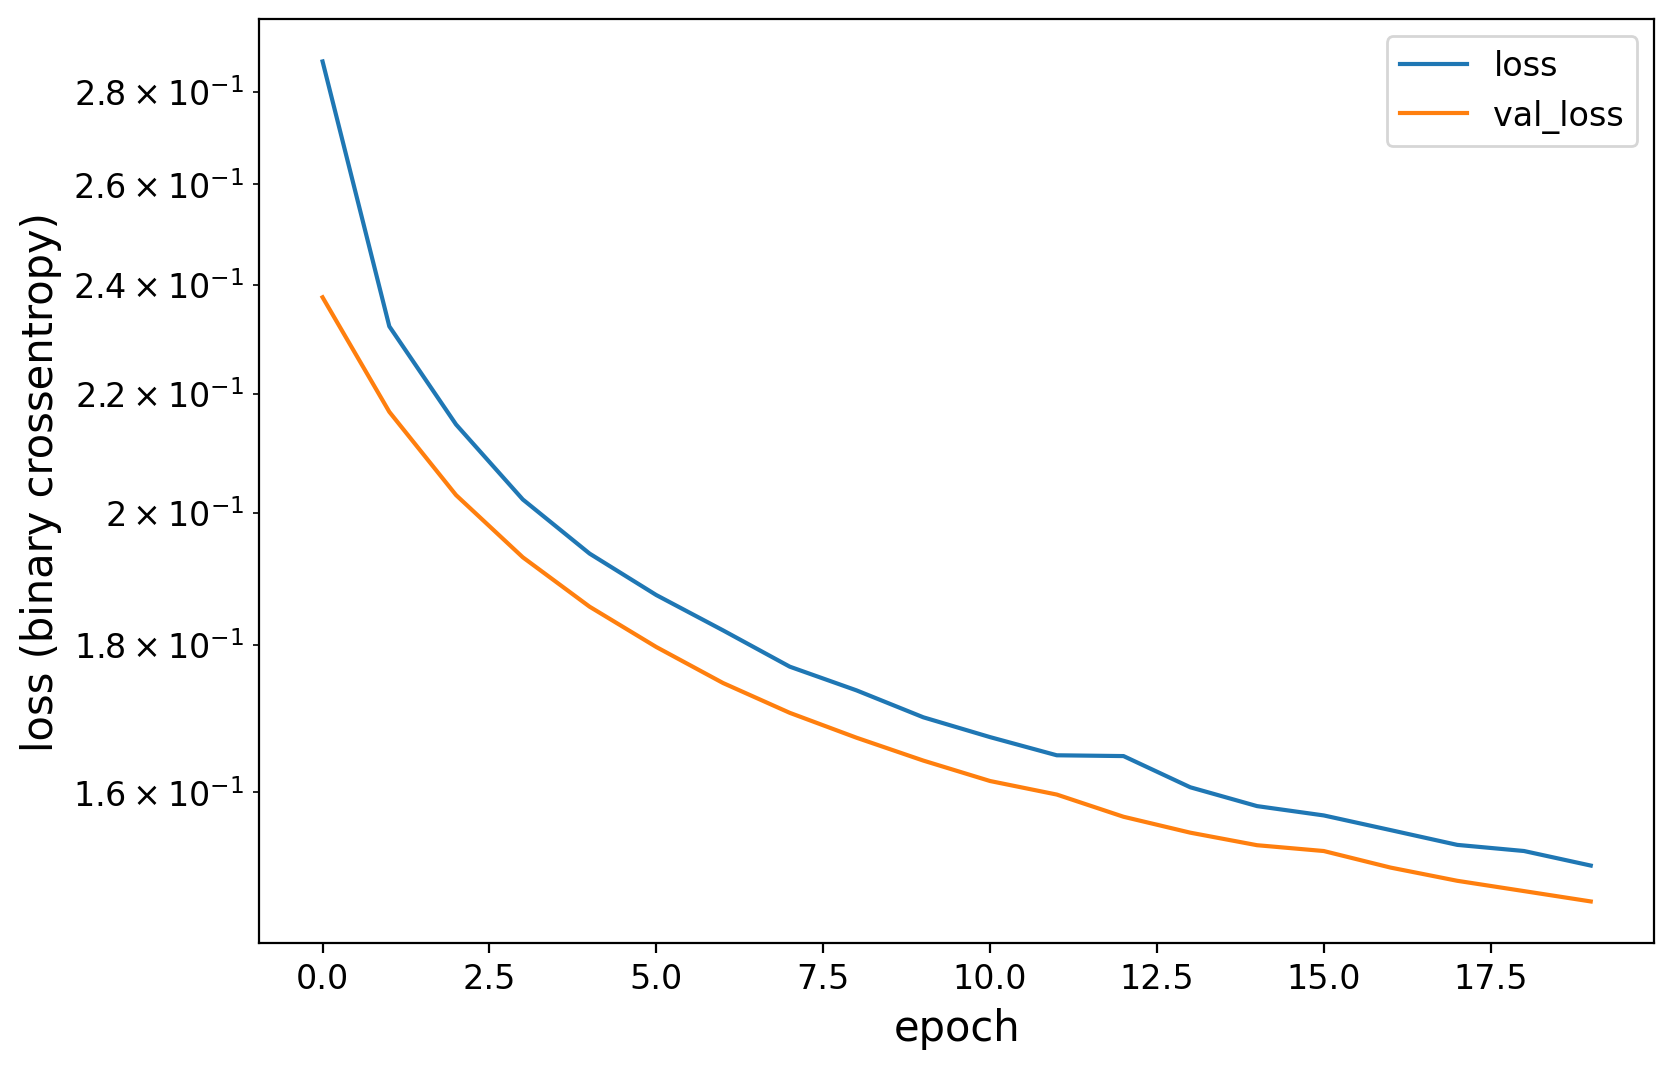

In [14]:
plt.semilogy(history_lr['loss'], label='loss')
plt.semilogy(history_lr['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

We start to see that our loss is converging.  Importantly, we also see that our validation and regular loss are similar. Interestingly, the validation loss is "better" that the training loss. We address that point below.

Sometimes overtraining can occur this is when the sensitivity starts to exceed the statistical precision of hte dataset and we start training on features in the data. When overtraining occurs the network starts to isolate features specific in teh training dataset and not the validaiton and our losses start to deviate. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.6.1</span>

We can approximate the uncertainty on the loss by the number of events assuming a poisson. Given that what is the statistical disagreement between signal and background? 

In [16]:
print(history_lr['loss'][-1]-history_lr['val_loss'][-1],"N:",len(dataset[:,4:-3]),"sigma",1./np.sqrt(0.1*len(dataset[:,4:-3])))

0.004263556051638834 N: 110000 sigma 0.009534625892455923


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
< 2 standard deviations
</pre>
        
**EXPLANATION:**
We see a deviation of less that 2 standard deviations. This seems quite likely. Its a sign that our loss agrees. 

</div>

<a name='section_12_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.7 Tuning the  training </h2>  


You may have heard of overtraining. Lets define a "stopping criteria" by using the validation loss. We will stop the training if the validation loss appears to have hit its minimum (but we will give it a few epochs to allow for local minimum or single-epoch spikes. There are other ways to define an early stopping criteria but this will do for now.

In [17]:
def train(model,trainloader,valloader,nepochs=100,lr=0.003,l2reg=0.,patience=5,name=None):

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2reg) 

    history = {'loss':[], 'val_loss':[]}

    min_loss = 999999.
    min_epoch = 0
    min_model = model.state_dict()
    should_stop = False
    
    for epoch in range(nepochs):

        current_loss = 0.0 #rezero loss

        for i, data in enumerate(trainloader):

            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # This will use the pytorch autograd feature to adjust the
            ## parameters of our function to minimize the loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            current_loss += loss.item()

            if i == len(trainloader)-1:
                current_val_loss = 0.0
                with torch.no_grad():#disable updating gradient
                    model.eval() #place model in evaluation state
                                ## necessary for some layer types (like dropout)
                    for iv, vdata in enumerate(valloader):
                        val_inputs, val_labels = vdata
                        val_loss = criterion(model(val_inputs), val_labels)
                        current_val_loss += val_loss.item()
                    model.train() #return to training state
                current_loss = current_loss/float(i+1)
                current_val_loss = current_val_loss/float(len(valloader))
                print('[%d, %4d] loss: %.4f  val loss: %.4f' % 
                      (epoch + 1, i + 1, current_loss , current_val_loss))

                ############ This is the new block
                if current_val_loss < min_loss:
                    min_loss = current_val_loss
                    min_model = model.state_dict()
                    min_epoch = epoch
                elif epoch-min_epoch==5:
                    model.load_state_dict(min_model)
                    should_stop = True
                    break

                history['loss'].append(current_loss)
                history['val_loss'].append(current_val_loss)
                
            if should_stop:
                break

    print('Finished Training')
    if name is not None:
        torch.save(model.state_dict(), '%s.pt'%name)
    return history

Let's now run for a number of epochs and see if we get out training to stop altogether. 

In [18]:
history_lr = train(model_lr,trainloader,valloader,name='lr_model')

[1,  124] loss: 0.1498  val loss: 0.1440
[2,  124] loss: 0.1465  val loss: 0.1423
[3,  124] loss: 0.1447  val loss: 0.1414
[4,  124] loss: 0.1450  val loss: 0.1396
[5,  124] loss: 0.1441  val loss: 0.1388
[6,  124] loss: 0.1426  val loss: 0.1380
[7,  124] loss: 0.1418  val loss: 0.1373
[8,  124] loss: 0.1411  val loss: 0.1371
[9,  124] loss: 0.1403  val loss: 0.1365
[10,  124] loss: 0.1395  val loss: 0.1360
[11,  124] loss: 0.1388  val loss: 0.1355
[12,  124] loss: 0.1387  val loss: 0.1354
[13,  124] loss: 0.1383  val loss: 0.1349
[14,  124] loss: 0.1381  val loss: 0.1345
[15,  124] loss: 0.1376  val loss: 0.1344
[16,  124] loss: 0.1373  val loss: 0.1339
[17,  124] loss: 0.1368  val loss: 0.1337
[18,  124] loss: 0.1363  val loss: 0.1336
[19,  124] loss: 0.1365  val loss: 0.1333
[20,  124] loss: 0.1367  val loss: 0.1331
[21,  124] loss: 0.1360  val loss: 0.1328
[22,  124] loss: 0.1355  val loss: 0.1328
[23,  124] loss: 0.1354  val loss: 0.1330
[24,  124] loss: 0.1356  val loss: 0.1326
[

Like before we can also see if our loss is behaving and make a judgetment on what is going on. 

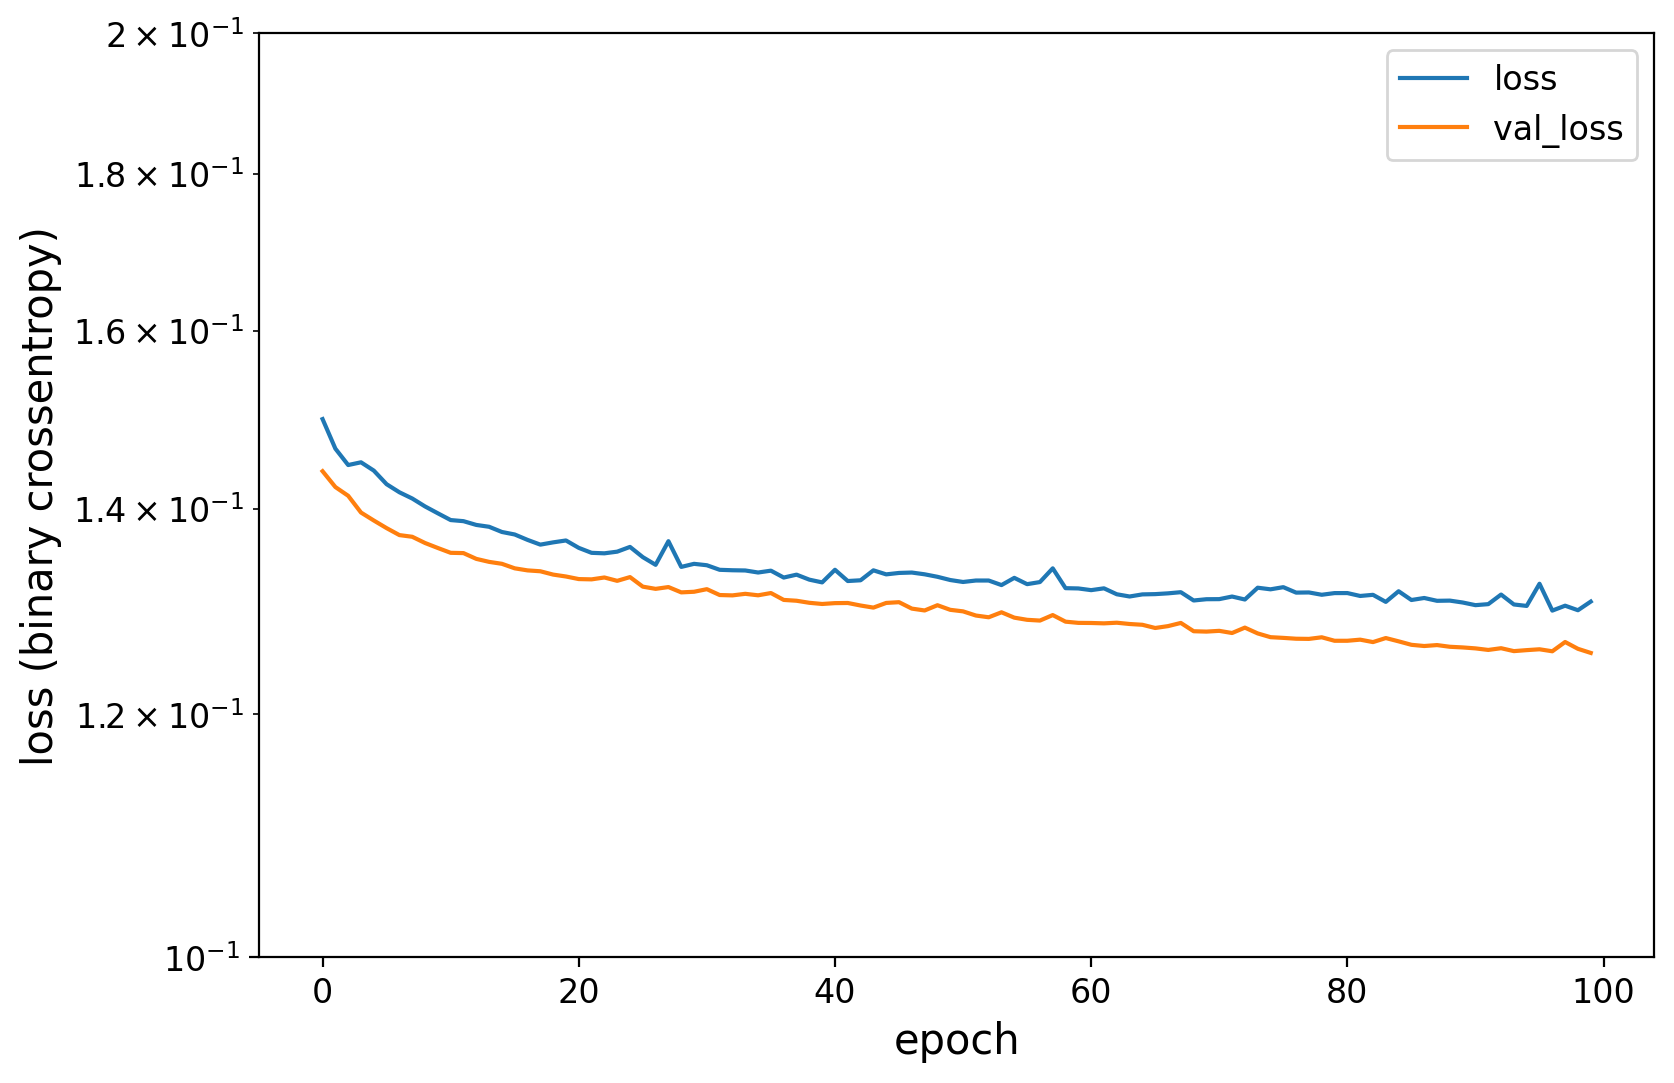

In [19]:
plt.semilogy(history_lr['loss'], label='loss')
plt.semilogy(history_lr['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.ylim(0.1,0.2)
plt.show()

Now lets see how to apply this network to our test data. This is essentially the same setup we used for the validation data.

In [20]:
def apply(model, testloader):
    with torch.no_grad():
        model.eval()
        outputs = []
        labels = []
        for data in testloader:
            test_inputs, test_labels = data
            outputs.append(model(test_inputs).numpy())
            labels.append(test_labels.numpy())
        model.train()

        Y_test_predict = outputs
        Y_test = labels

    Y_test_predict = np.concatenate(Y_test_predict)
    Y_test = np.concatenate(Y_test)
    
    return Y_test_predict,Y_test

Y_test_predict_lr, Y_test = apply(model_lr, testloader)

print(Y_test_predict_lr.shape)
print(Y_test.shape)

(33000, 1)
(33000, 1)


And now lets plot the distribution of the output of the network. As we wanted, the background (red) is peaked at 0, while the EG (blue) is closer to 1. 

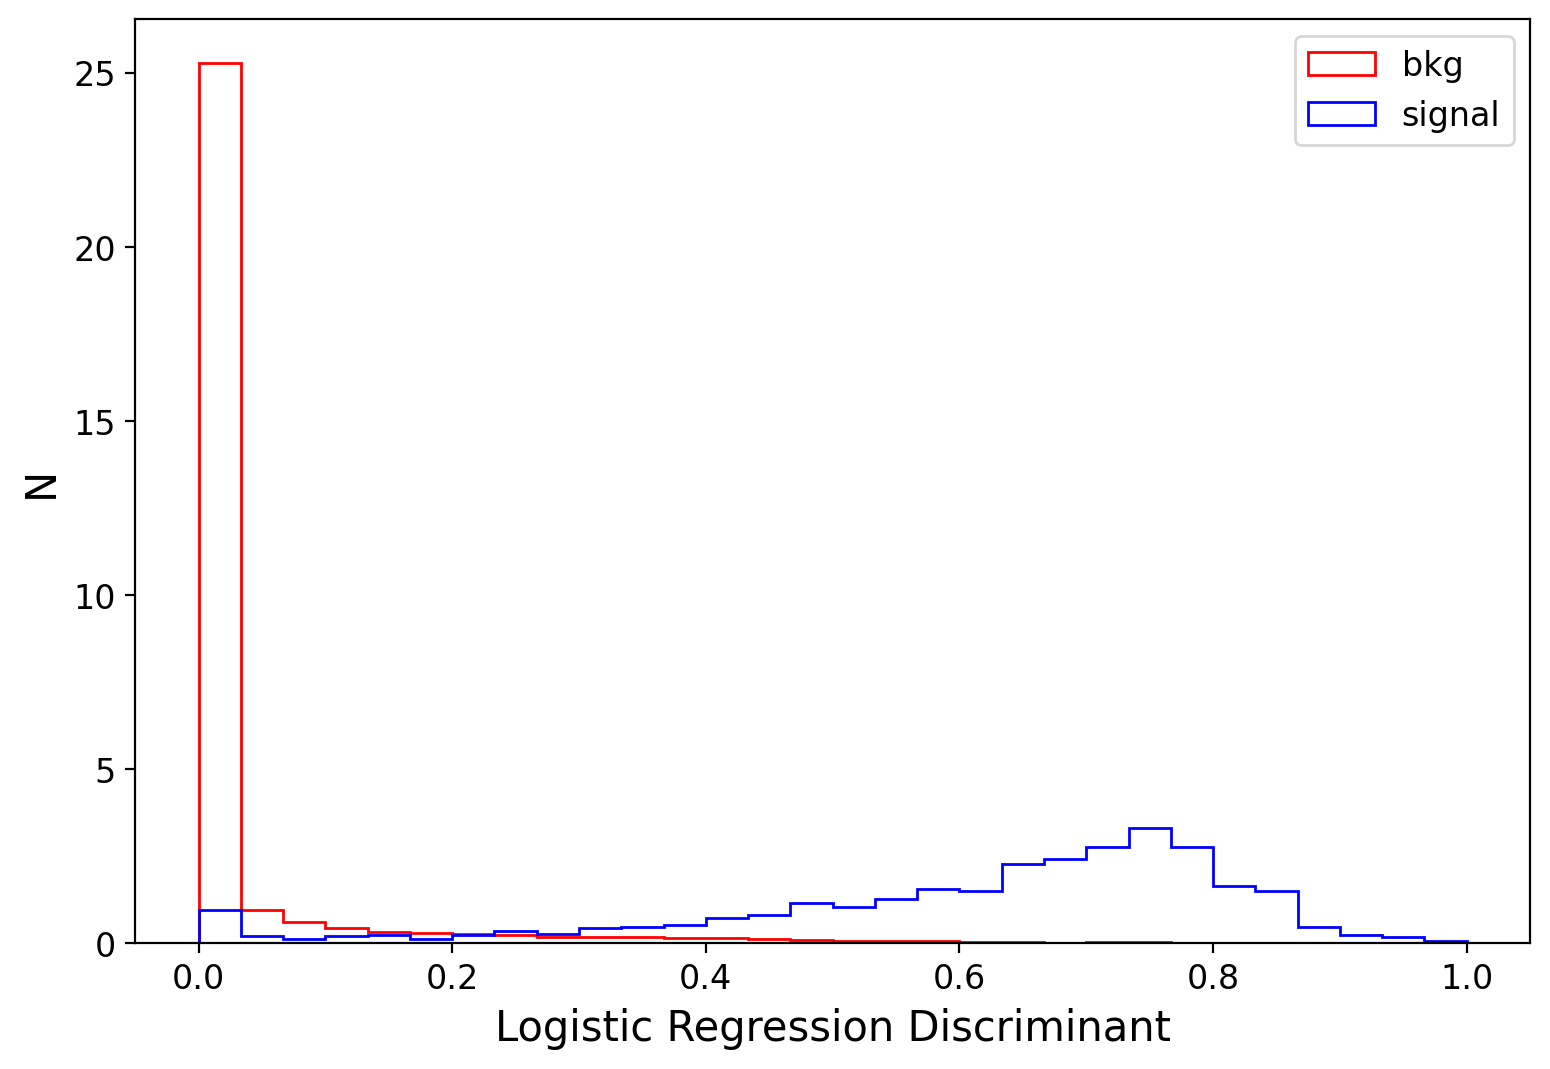

In [21]:
plt.hist(Y_test_predict_lr[Y_test==0],histtype='step',color='r',density=True,label='bkg',bins=30)
plt.hist(Y_test_predict_lr[Y_test==1],histtype='step',color='b',density=True,label='signal',bins=30)
plt.xlabel('Logistic Regression Discriminant')
plt.ylabel('N')
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.7.1</span>

A common way to select events from a discriminator is to make the normalized histograms (ie with the same integral) as is done above and to select only events above the line where the histograms cross. What fraction of signal events are above the bin of intersection for signal and background? 


In [16]:
print("Signal",len(Y_test_predict_lr[Y_test==1][Y_test_predict_lr[Y_test==1] > 0.20])/len(Y_test_predict_lr[Y_test==1]))
print("Big:"  ,len(Y_test_predict_lr[Y_test==0][Y_test_predict_lr[Y_test==0] > 0.20])/len(Y_test_predict_lr[Y_test==0]))


Signal 0.9412962334577536
Big: 0.10152064685721891


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
93% signal and 7% background
</pre>
        
**EXPLANATION:**
Interestingly where pdfs cross on a distribution is often when the integrals between the distributions greater than and/or below than are roughly equal. This is also often close to the optimal point where we want to select events. In reality the optimal point is specific to the problem, but ths is a quick way to judge by eye.  

</div>

<a name='section_12_8'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.8 Making the network more complicated </h2>  


What we did above was a small 1-layer network and really not representative of the power of deep learning. Instead of just a few weights, lets now pump up the number of free parameters by adding a variety of layers. This will allow us to be much more expressive in the way we can discrminate events. Let's start by declaring the updated model.  

In [65]:
class MLP2_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,30)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(30,10)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(10,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.output(x)
        return x
    

model_mlp_2layer = MLP2_net()
print(model_mlp_2layer)

MLP2_net(
  (fc1): Linear(in_features=19, out_features=30, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
)


Now we can go ahed and train. Pay attention to the loss value compared to before, you should already start to see signs that the performance is better because we have now made the model much more expressive by adding a second layer. Let's go ahead. 

In [66]:
history_mlp_2layer = train(model_mlp_2layer,trainloader,valloader,name='mlp_2layer_model')
Y_test_predict_mlp_2layer, Y_test = apply(model_mlp_2layer, testloader)

[1,  124] loss: 0.2458  val loss: 0.1499
[2,  124] loss: 0.1408  val loss: 0.1294
[3,  124] loss: 0.1275  val loss: 0.1223
[4,  124] loss: 0.1102  val loss: 0.0978
[5,  124] loss: 0.0957  val loss: 0.0931
[6,  124] loss: 0.0917  val loss: 0.0908
[7,  124] loss: 0.0888  val loss: 0.0919
[8,  124] loss: 0.0890  val loss: 0.0880
[9,  124] loss: 0.0879  val loss: 0.0911
[10,  124] loss: 0.0872  val loss: 0.0894
[11,  124] loss: 0.0864  val loss: 0.0859
[12,  124] loss: 0.0844  val loss: 0.0872
[13,  124] loss: 0.0850  val loss: 0.0866
[14,  124] loss: 0.0845  val loss: 0.0850
[15,  124] loss: 0.0838  val loss: 0.0852
[16,  124] loss: 0.0844  val loss: 0.0884
[17,  124] loss: 0.0829  val loss: 0.0879
[18,  124] loss: 0.0824  val loss: 0.0837
[19,  124] loss: 0.0829  val loss: 0.0857
[20,  124] loss: 0.0813  val loss: 0.0845
[21,  124] loss: 0.0815  val loss: 0.0832
[22,  124] loss: 0.0816  val loss: 0.0825
[23,  124] loss: 0.0817  val loss: 0.0836
[24,  124] loss: 0.0804  val loss: 0.0834
[

Like we did before, we can again go ahead and scan our training ot make sure we our loss is close to convergence and we haven't overtrained.  

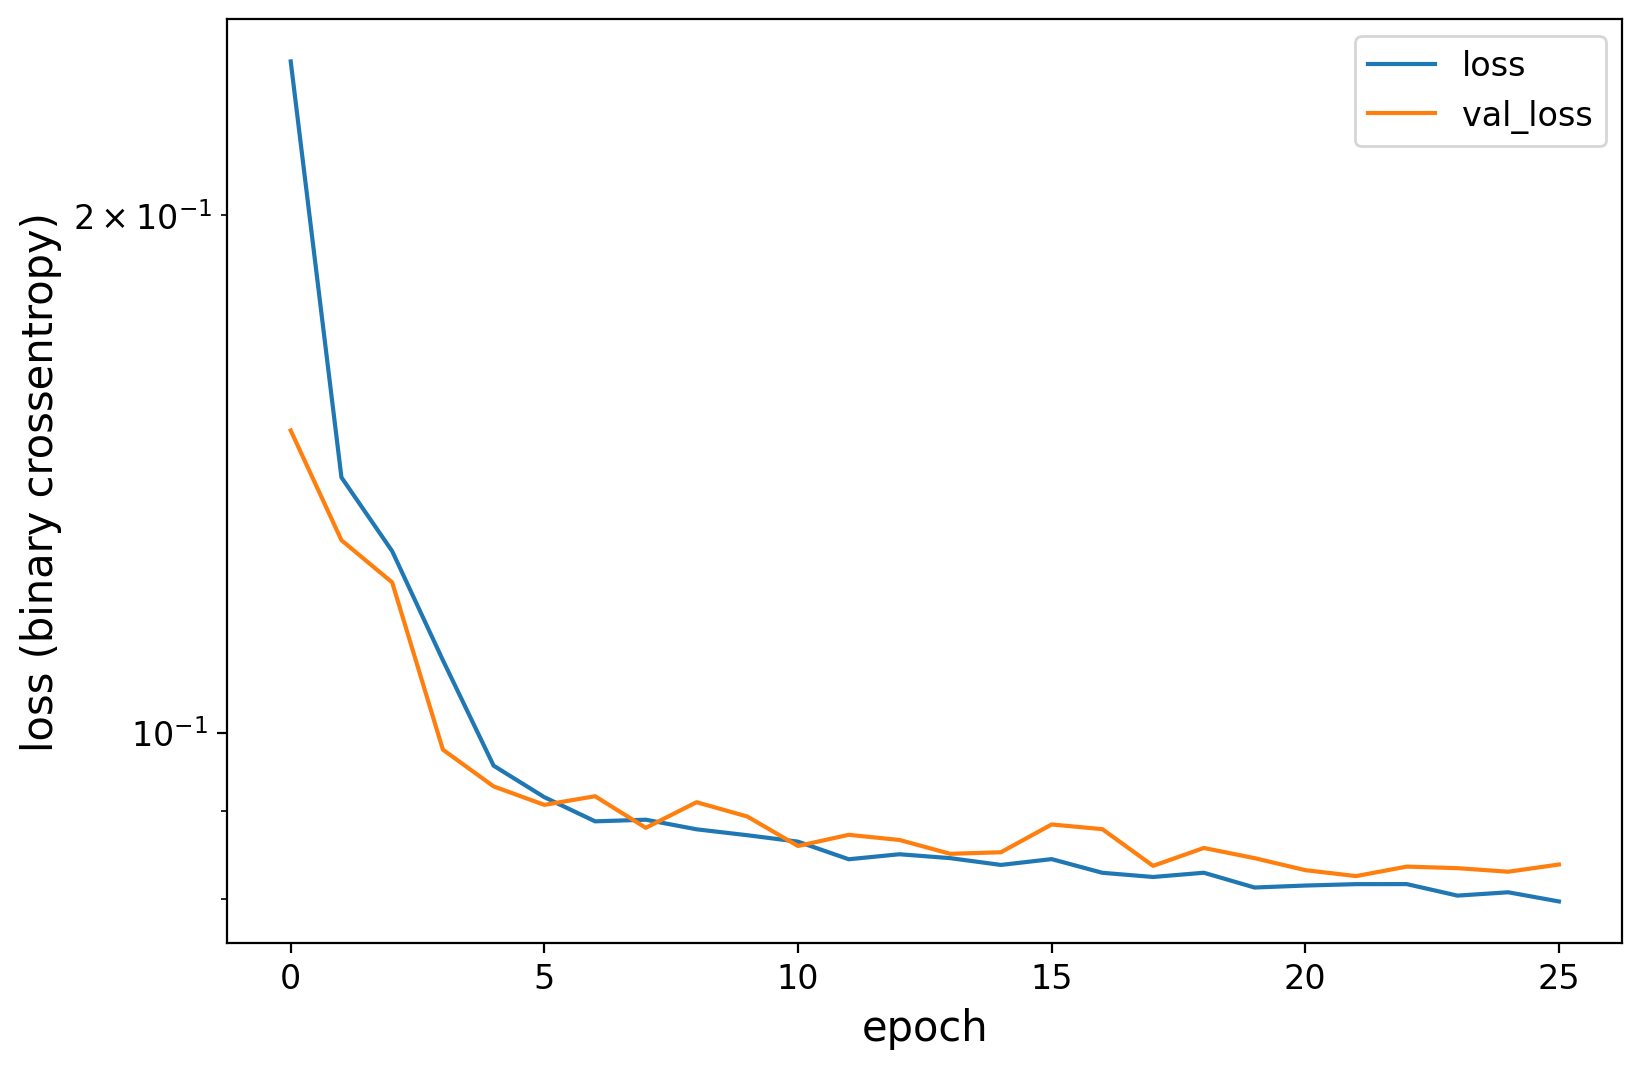

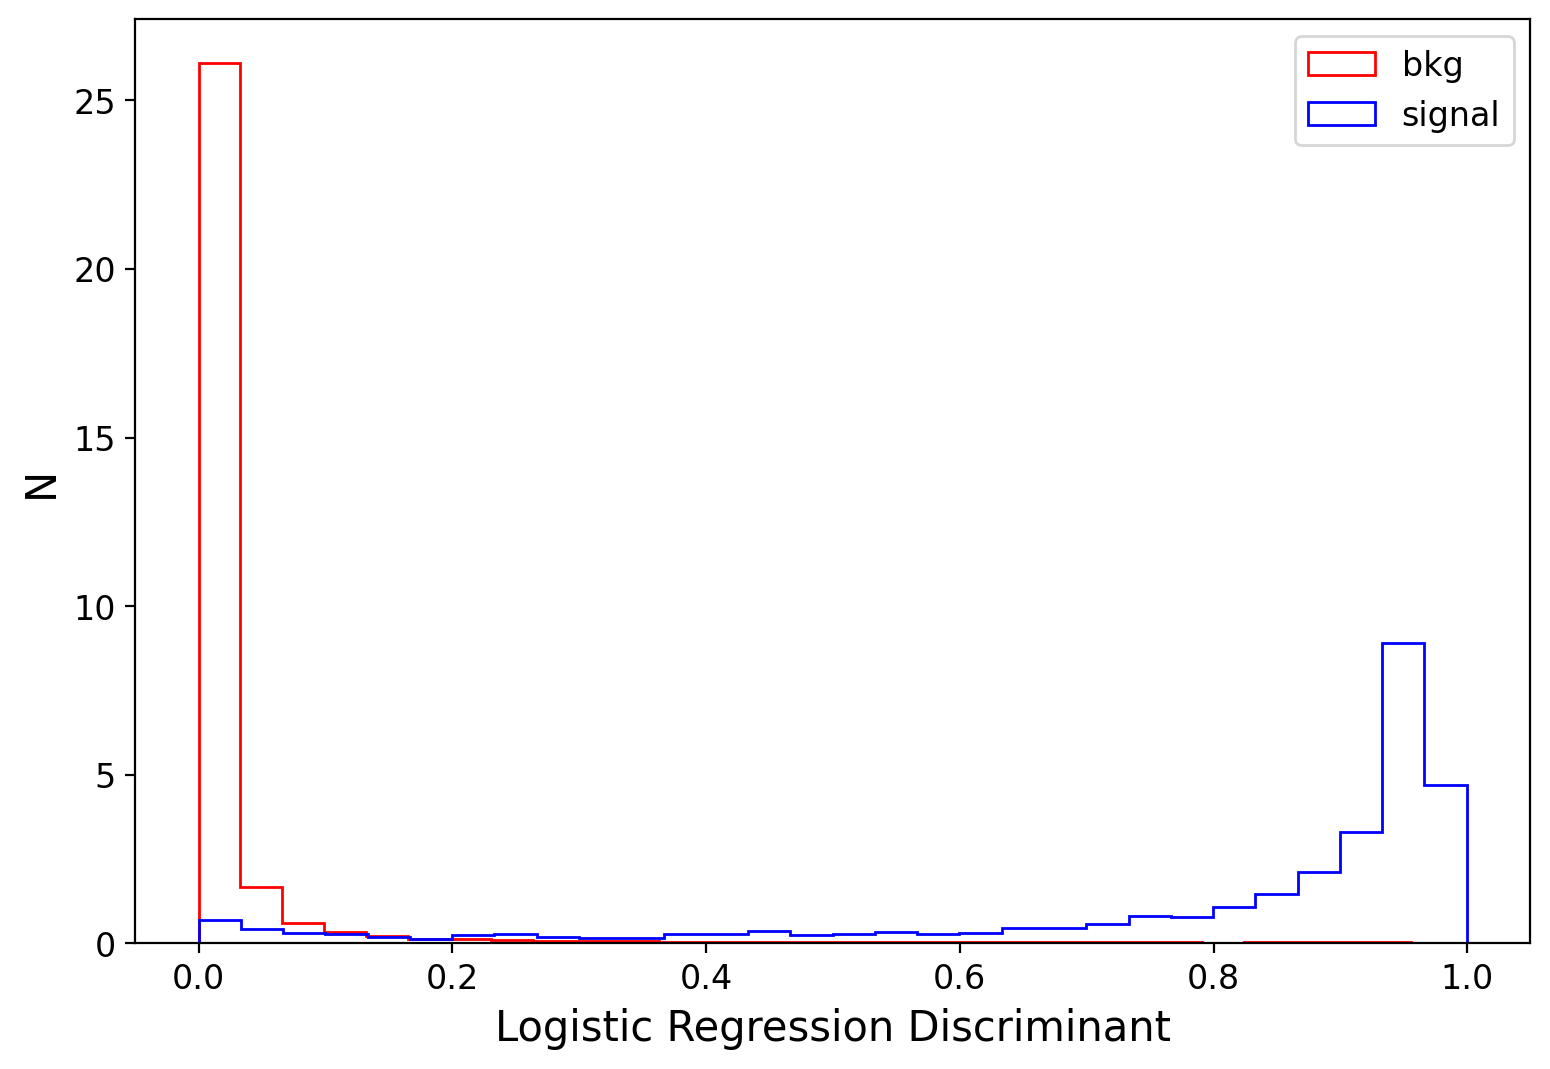

In [67]:
plt.semilogy(history_mlp_2layer['loss'], label='loss')
plt.semilogy(history_mlp_2layer['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

plt.hist(Y_test_predict_mlp_2layer[Y_test==0],histtype='step',color='r',density=True,label='bkg',bins=30)
plt.hist(Y_test_predict_mlp_2layer[Y_test==1],histtype='step',color='b',density=True,label='signal',bins=30)
plt.xlabel('MLP (2 hidden layers) Discriminant')
plt.xlabel('Logistic Regression Discriminant')
plt.ylabel('N')
plt.legend()
plt.show()

Following the problem that we did above, we can also go ahead and check the signal and background efficiencies, and we see that we do have more signal for more background rejection. 

In [68]:
print("Signal",len(Y_test_predict_lr[Y_test==1][Y_test_predict_lr[Y_test==1] > 0.20])/len(Y_test_predict_lr[Y_test==1]))
print("Big:"  ,len(Y_test_predict_lr[Y_test==0][Y_test_predict_lr[Y_test==0] > 0.20])/len(Y_test_predict_lr[Y_test==0]))


Signal 0.930081855388813
Big: 0.07443128907808966


This looks better than the logistic regression. But how would we establish that? A Receiver Operating Characteristic (ROC) curve is a typical way to compare multiple algorithms. Basically we are going to make a requirement on the NN output: if it is below a given value we will call it background, and if it is above that value its EG. Then we compute how good this is at predicting the true labels. We can scan this cutoff value between 0 and 1 and then plot each point.

More specifically, we can define two axes for the ROC as 

 * $\epsilon_{s}=\int_{x}^{\infty} {\rm Disc}(x|x_{i}\in{\rm Signal}) dx$
 * $\epsilon_{b}=\int_{x}^{\infty} {\rm Disc}(x|x_{i}\in{\rm Background}) dx$

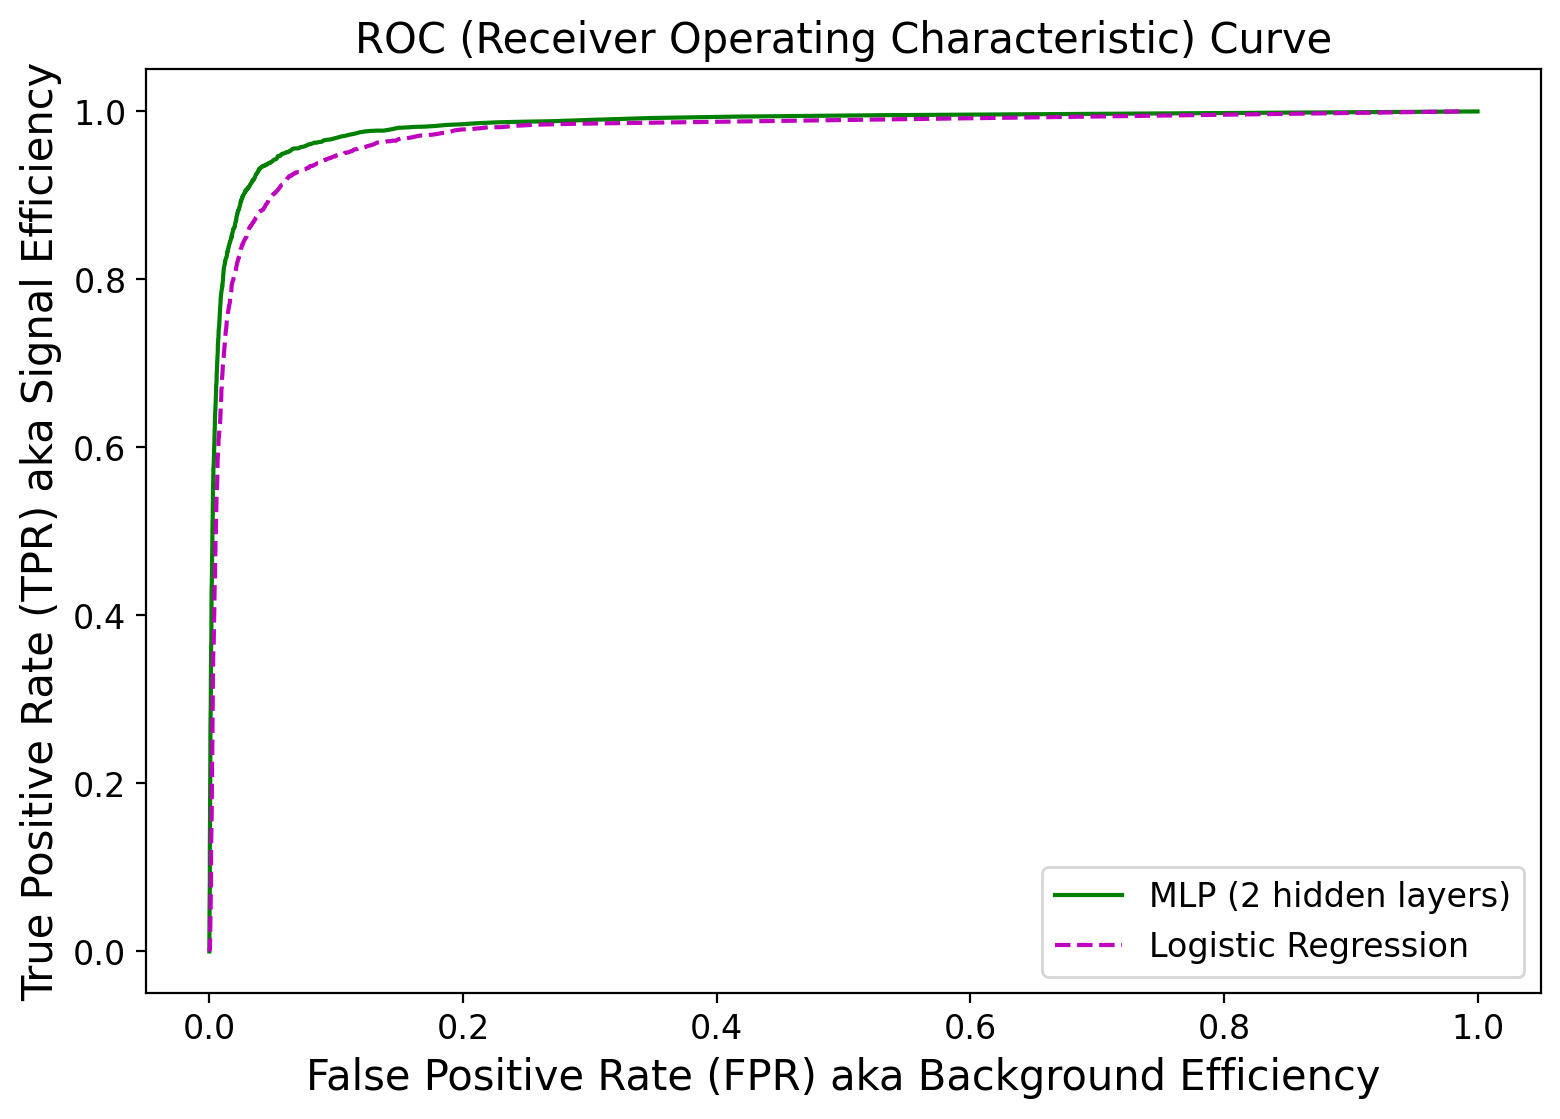

In [69]:
def compute_ROC(labels, predicts, npts=501):
    cutvals = np.linspace(0.,1.,num=npts)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)
    
    return np.array(fpr),np.array(tpr)

mlp_2layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_2layer)
lr_rocpts = compute_ROC(Y_test,Y_test_predict_lr)

plt.plot(mlp_2layer_rocpts[0],mlp_2layer_rocpts[1],'g-',label="MLP (2 hidden layers)")
plt.plot(lr_rocpts[0],lr_rocpts[1],'m--',label="Logistic Regression")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

Reading a ROC can take a second if you haven't done this before. The key is to get things in the top left corder, the more you get to the top left the better since you reject more background (left) with higher efficiency (top). 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.8.1</span>

When we compare the performance of two algorithms, we often like to fix the signal efficiency and look at the background rejection change. For a fixed signal efficiency of 97% what is the reduction from logistic to MLP? 


In [70]:
print(mlp_2layer_rocpts[1][30:31],mlp_2layer_rocpts[0][30:31])
print(lr_rocpts[1][5:7],lr_rocpts[0][5:7])
#plt.plot(mlp_2layer_rocpts[0],mlp_2layer_rocpts[1],'g-',label="MLP (2 hidden layers)")
#plt.plot(lr_rocpts[0],lr_rocpts[1],'m--',label="Logistic Regression")


[0.96555252] [0.09026207]
[0.98124147 0.97987722] [0.22003459 0.21251829]


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
10% for backgound with the MLP and 20% for the logistic regerssion
</pre>
        
**EXPLANATION:**
We reduce our bakground by a factor of 10/20 this is a 50% reduction in background, which is very substantial. 
    
</div>

<a name='section_12_9'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.9 Regularziation and Network Tuning </h2>  


So the MLP we made is indeed a bit better, especially if we want to classify the background very well.

Lets try a larger network. Also, lets through at our network some other techniques to really improve the quality of our training.  

In [18]:
class MLP3_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,50)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(50,30)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(30,10)
        self.act3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(10,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x
    

model_mlp_3layer = MLP3_net()
print(model_mlp_3layer)

MLP3_net(
  (fc1): Linear(in_features=19, out_features=50, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=30, out_features=10, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
)


Lets also try to use a form of regularization, in this case L2. If left unchecked, larger networks especially can begin to find and abuse certain subtle features that we perhaps don't want them to. The obvious case is if the feature is only present in the training set then we may be hurting ourselves by focusing on that. L2 regularization adds a "penalty term" to the loss function which is a function of the magnitude squared of the weight values. 

$\mathcal{L} = \mathcal{L}_\textrm{BCE} + \lambda\sum_{i} |W_{i}|^2$

We can control the relative importance of this term via the $\lambda$ parameter. By encouraging the network to keep the weights small, it is less able to magnify the importance of one particular feature/node. In pytorch this done by adding options to the optimizer.  

In [19]:
#We add teh l2 regularization to the optimzer, which automatically modifies the loss
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2reg) 
model_mlp_3layer.load_state_dict(torch.load('mlp_3layer_model.pt'))

history_mlp_3layer = train(model_mlp_3layer,trainloader,valloader,l2reg=0.0001,name='mlp_3layer_model')
Y_test_predict_mlp_3layer, Y_test = apply(model_mlp_3layer, testloader)

NameError: name 'train' is not defined

We can see that this larger model gets to a lower loss in less epochs. The training is a bit slower though. We are definitely better, and we aren't waiting a huge amount of time to train this network. 

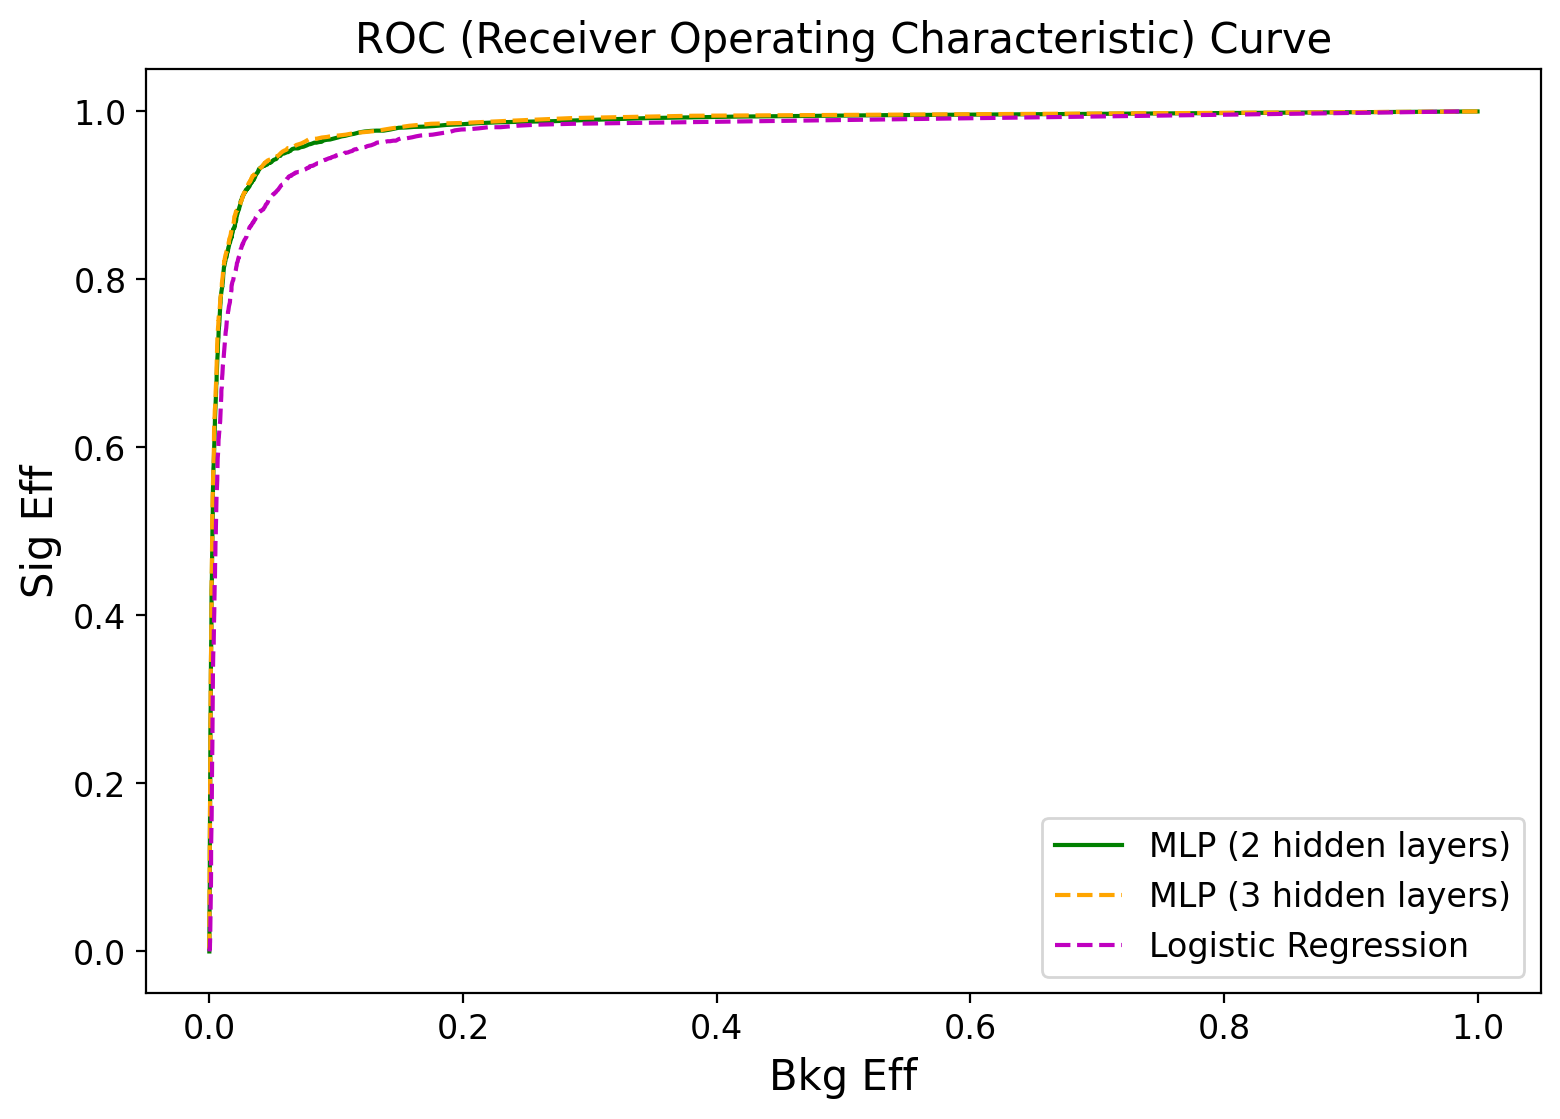

In [73]:
mlp_2layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_2layer)
mlp_3layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer)
lr_rocpts = compute_ROC(Y_test,Y_test_predict_lr)

plt.plot(mlp_2layer_rocpts[0],mlp_2layer_rocpts[1],'g-',label="MLP (2 hidden layers)")
plt.plot(mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
plt.plot(lr_rocpts[0],lr_rocpts[1],'m--',label="Logistic Regression")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("Bkg Eff")
plt.ylabel("Sig Eff")
plt.legend(loc="lower right")
plt.show()

Its hard to tell... Luckily we are not required to plot $\epsilon_{s}$ and $\epsilon_{b}$. Lets use $1/\epsilon_{b}$ instead of $\epsilon_{b}$ to really bring out the behavior for low $\epsilon_{b}$. From this you can see very large gains present in the background rejection especailly at lower signal efficiency. 

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1548690287.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1./mlp_2layer_rocpts[0],mlp_2layer_rocpts[1],'g-',label="MLP (2 hidden layers)")
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1548690287.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1./mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1548690287.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1./lr_rocpts[0],lr_rocpts[1],'m--',label="Logistic Regression")


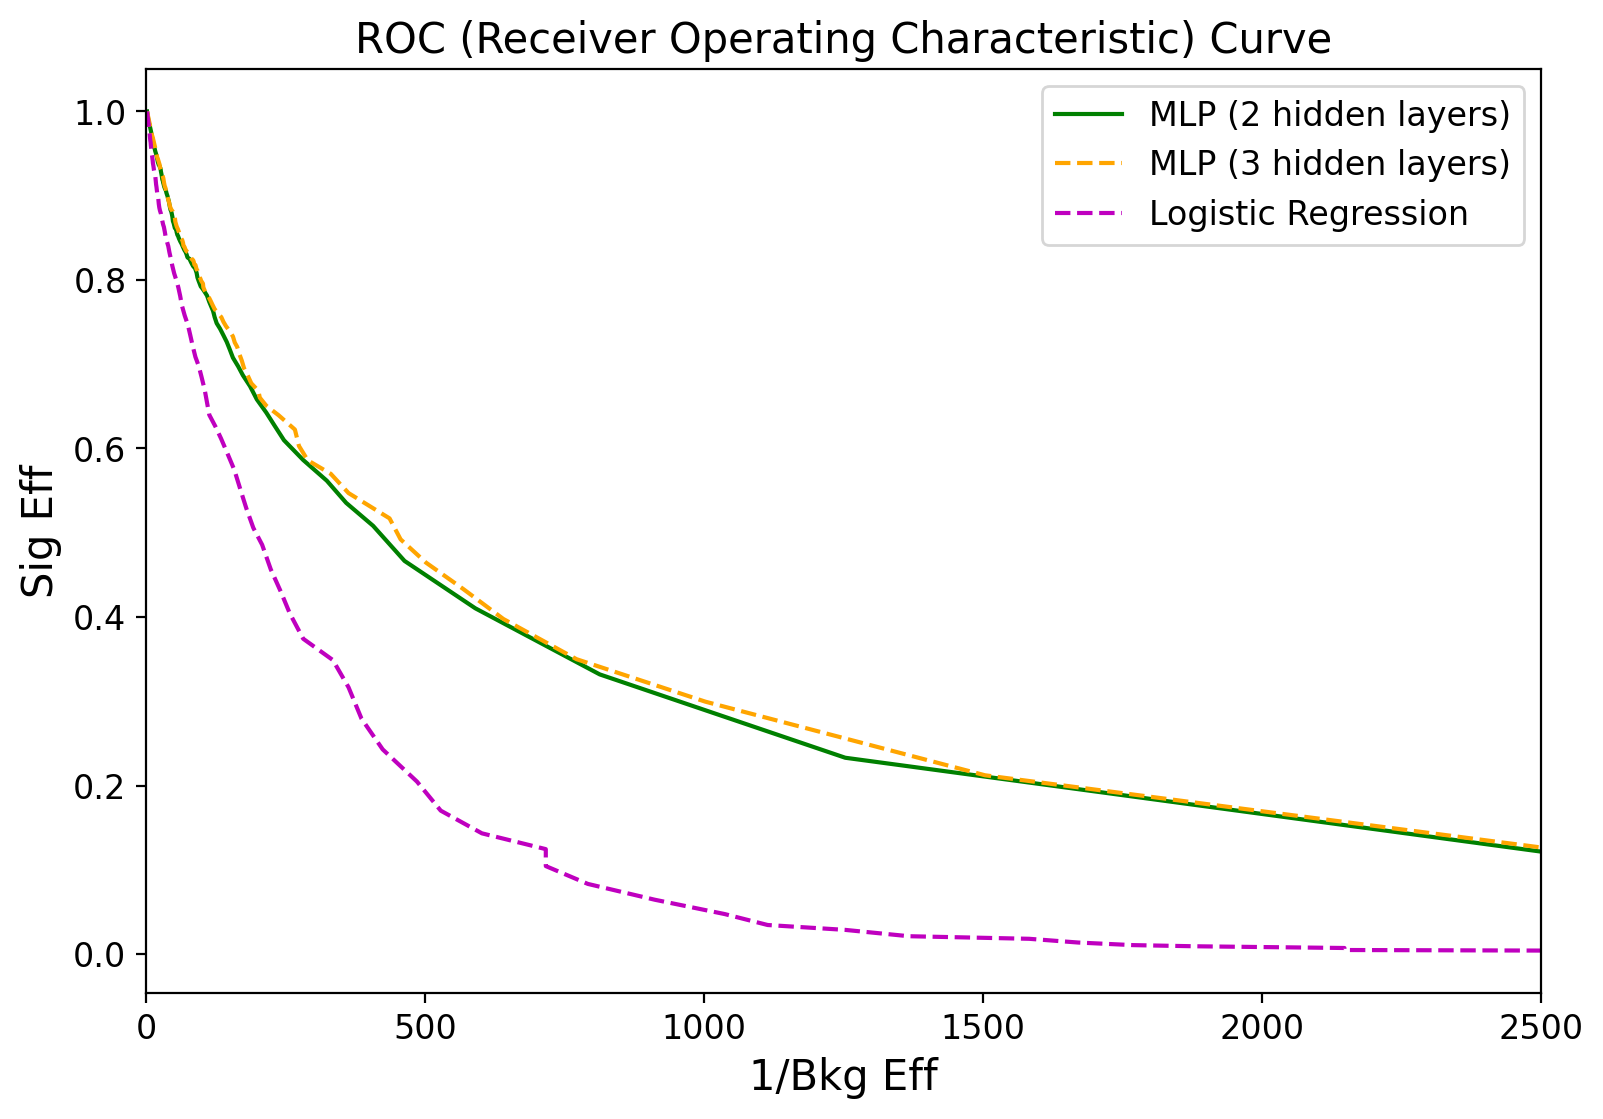

In [74]:
mlp_2layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_2layer,101)
mlp_3layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer,101)
lr_rocpts = compute_ROC(Y_test,Y_test_predict_lr,101)

plt.plot(1./mlp_2layer_rocpts[0],mlp_2layer_rocpts[1],'g-',label="MLP (2 hidden layers)")
plt.plot(1./mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
plt.plot(1./lr_rocpts[0],lr_rocpts[1],'m--',label="Logistic Regression")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("1/Bkg Eff")
plt.xlim([-1, 2500])
plt.ylabel("Sig Eff")
plt.legend(loc="upper right")
plt.show()

Lets try two other types of regularizer to finish: *batch normalization* and *dropout*.

Batch normalization works by rescaling each input such that the mean and standard deviation are 0 and 1, respectively. This helps make sure that each node has similar values when it is passed to the following layer.

Dropout works by randomly removing a given fraction of the nodes in a layer each training pass. This helps ensure that no one node becomes crucially important to the final result.

In [75]:
class MLP3_BN_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = torch.nn.BatchNorm1d(ninputs)
        self.fc1 = torch.nn.Linear(ninputs,50)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(50)
        self.fc2 = torch.nn.Linear(50,30)
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(30)
        self.fc3 = torch.nn.Linear(30,10)
        self.act3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm1d(10)
        self.fc4 = torch.nn.Linear(10,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x
    
class MLP3_Drop_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,50)
        self.act1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(50,30)
        self.act2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout(0.1)
        self.fc3 = torch.nn.Linear(30,10)
        self.act3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout(0.1)
        self.fc4 = torch.nn.Linear(10,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.drop3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x

model_mlp_3layer_bn = MLP3_BN_net()
model_mlp_3layer_bn.load_state_dict(torch.load('mlp_3layer_bn_model.pt'))
print(model_mlp_3layer_bn)

model_mlp_3layer_drop = MLP3_Drop_net()
model_mlp_3layer_drop.load_state_dict(torch.load('mlp_3layer_drop_model.pt'))
print(model_mlp_3layer_drop)

MLP3_BN_net(
  (bn0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=19, out_features=50, bias=True)
  (act1): ReLU()
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (act2): ReLU()
  (bn2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
  (act3): ReLU()
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
)
MLP3_Drop_net(
  (fc1): Linear(in_features=19, out_features=50, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
  (act

In [76]:
history_mlp_3layer_bn = train(model_mlp_3layer_bn,trainloader,valloader,name='mlp_3layer_bn_model',nepochs=2)
Y_test_predict_mlp_3layer_bn, Y_test = apply(model_mlp_3layer_bn, testloader)

[1,  124] loss: 0.0734  val loss: 0.1210
[2,  124] loss: 0.0729  val loss: 0.1144
Finished Training


In [77]:
history_mlp_3layer_drop = train(model_mlp_3layer_drop,trainloader,valloader,name='mlp_3layer_drop_model',nepochs=2)
Y_test_predict_mlp_3layer_drop, Y_test = apply(model_mlp_3layer_drop, testloader)

[1,  124] loss: 0.0879  val loss: 0.0845
[2,  124] loss: 0.0855  val loss: 0.0806
Finished Training


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1124294701.py:15: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1124294701.py:16: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./mlp_3layer_bn_rocpts[0],mlp_3layer_bn_rocpts[1],'--',color='brown',label="MLP (3 hidden layers w/ BN)")
/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_48245/1124294701.py:17: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(1./mlp_3layer_drop_rocpts[0],mlp_3layer_drop_rocpts[1],'--',color='cyan',label="MLP (3 hidden layers w/ Dropout)")


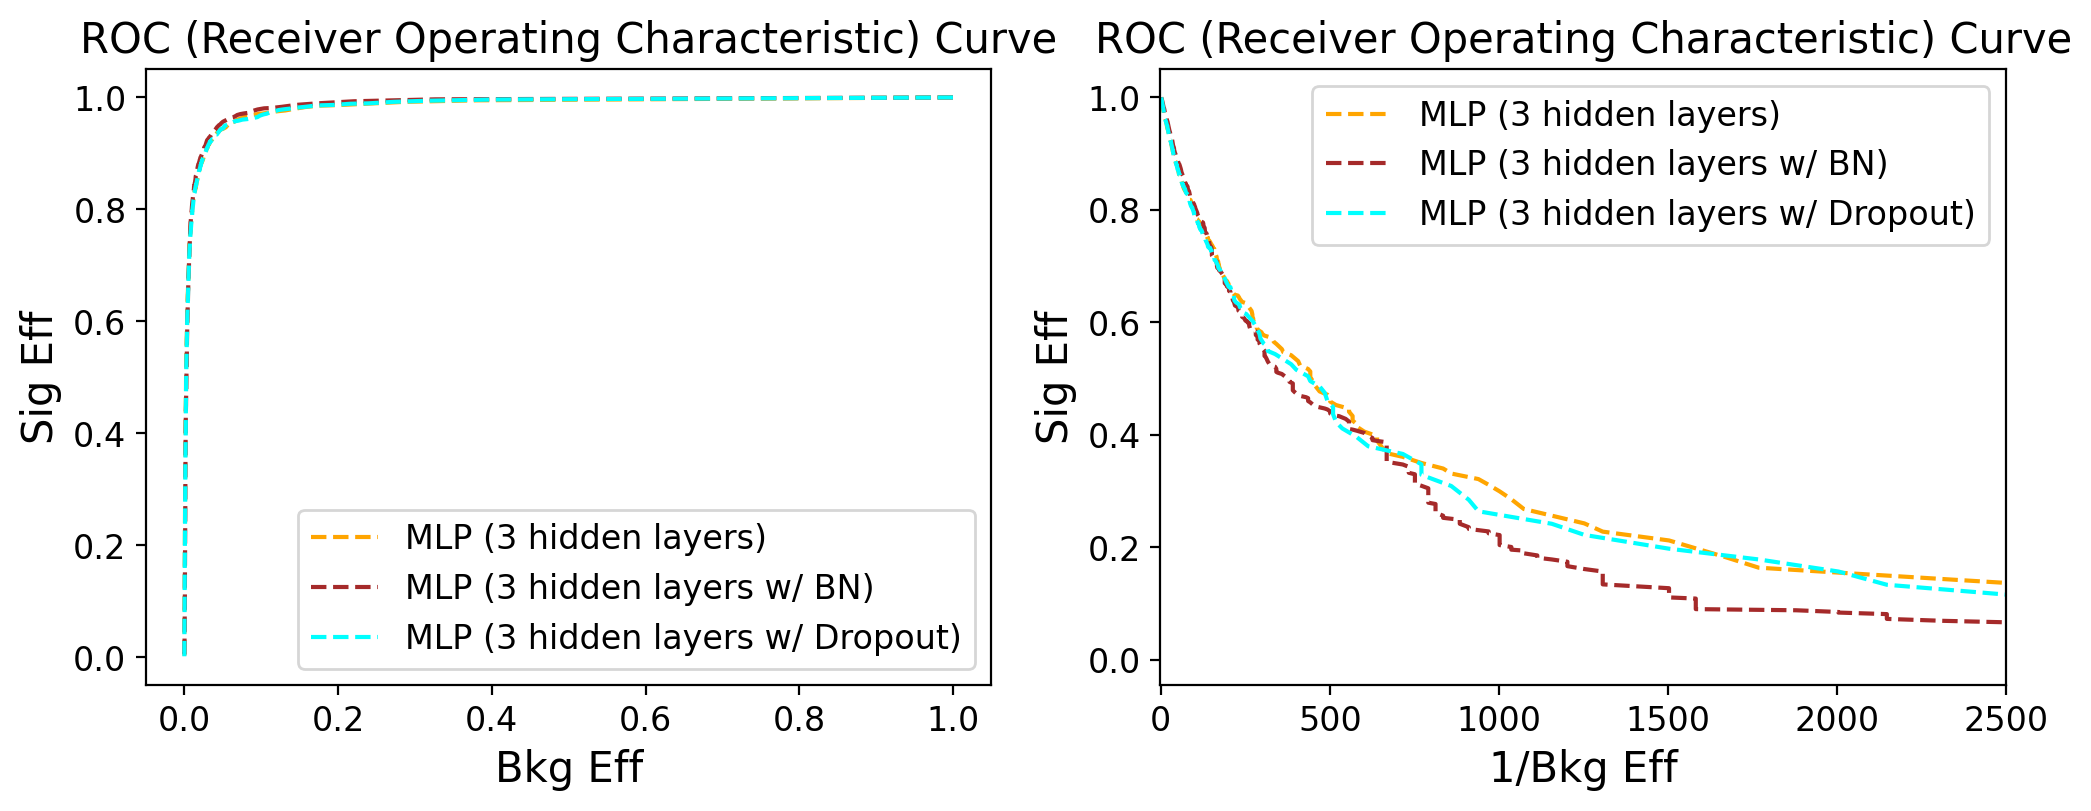

In [78]:
mlp_3layer_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer,501)
mlp_3layer_bn_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer_bn,501)
mlp_3layer_drop_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer_drop,501)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
ax1.plot(mlp_3layer_bn_rocpts[0],mlp_3layer_bn_rocpts[1],'--',color='brown',label="MLP (3 hidden layers w/ BN)")
ax1.plot(mlp_3layer_drop_rocpts[0],mlp_3layer_drop_rocpts[1],'--',color='cyan',label="MLP (3 hidden layers w/ Dropout)")
ax1.set_title("ROC (Receiver Operating Characteristic) Curve")
ax1.set_xlabel("Bkg Eff")
ax1.set_ylabel("Sig Eff")
ax1.legend(loc="lower right")

ax2.plot(1./mlp_3layer_rocpts[0],mlp_3layer_rocpts[1],'--',color='orange',label="MLP (3 hidden layers)")
ax2.plot(1./mlp_3layer_bn_rocpts[0],mlp_3layer_bn_rocpts[1],'--',color='brown',label="MLP (3 hidden layers w/ BN)")
ax2.plot(1./mlp_3layer_drop_rocpts[0],mlp_3layer_drop_rocpts[1],'--',color='cyan',label="MLP (3 hidden layers w/ Dropout)")
ax2.set_title("ROC (Receiver Operating Characteristic) Curve")
ax2.set_xlabel("1/Bkg Eff")
ax2.set_xlim([-1, 2500])
ax2.set_ylabel("Sig Eff")
ax2.legend(loc="upper right")

plt.show()

You should now have all the tools you need to start developing, training, and testing your own own neural networks!

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.9.1</span>

For a fixed signal efficiency of 97% what is the reduction now for a 3 hidden layer when adding Batch norm and dropout?


In [80]:
print(mlp_3layer_rocpts[1][13:15],mlp_3layer_rocpts[0][13:15])
print(mlp_3layer_bn_rocpts[1][11:13],mlp_3layer_bn_rocpts[0][11:13])
print(mlp_3layer_drop_rocpts[1][17:19],mlp_3layer_drop_rocpts[0][17:19])


[0.97100955 0.96964529] [0.09734602 0.09278968]
[0.97135061 0.97032742] [0.07705867 0.07293468]
[0.96964529 0.96759891] [0.10276706 0.09834375]


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
12% for backgound with the 3 layer, then 8% for for Batch norm and 11.7% for dropout.
</pre>
        
**EXPLANATION:**
Batch norm seems to really help. This makes the netowrk more performant.     
</div>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.9.2</span>

Combine droput and batchnorm do you get even better performance? 

In [79]:
class MLP3_BN_Dropout_net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = torch.nn.BatchNorm1d(ninputs)
        self.fc1 = torch.nn.Linear(ninputs,50)
        self.act1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout(0.1)
        self.bn1 = torch.nn.BatchNorm1d(50)
        self.fc2 = torch.nn.Linear(50,30)
        self.act2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(30)
        self.drop2 = torch.nn.Dropout(0.1)
        self.fc3 = torch.nn.Linear(30,10)
        self.act3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm1d(10)
        self.drop3 = torch.nn.Dropout(0.1)
        self.fc4 = torch.nn.Linear(10,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.drop3(x)
        x = self.fc4(x)
        x = self.output(x)
        return x

model_mlp_3layer_bn_drop = MLP3_BN_Dropout_net()
model_mlp_3layer_bn.load_state_dict(torch.load('mlp_3layer_bn_drop_model.pt'))
history_mlp_3layer_bn_drop = train(model_mlp_3layer_bn_drop,trainloader,valloader,name='mlp_3layer_bn_drop_model',nepochs=100)
Y_test_predict_mlp_3layer_bn_drop, Y_test = apply(model_mlp_3layer_bn_drop, testloader)

mlp_3layer_bn_drop_rocpts = compute_ROC(Y_test,Y_test_predict_mlp_3layer_bn_drop,501)
print(mlp_3layer_bn_drop_rocpts[1][11:13],mlp_3layer_bn_drop_rocpts[0][11:13])


[1,  124] loss: 0.3823  val loss: 0.1634
[2,  124] loss: 0.1473  val loss: 0.1169
[3,  124] loss: 0.1112  val loss: 0.0943
[4,  124] loss: 0.1020  val loss: 0.1169
[5,  124] loss: 0.0977  val loss: 0.0906
[6,  124] loss: 0.0950  val loss: 0.0917
[7,  124] loss: 0.0914  val loss: 0.1236
[8,  124] loss: 0.0900  val loss: 0.1196
[9,  124] loss: 0.0873  val loss: 0.0993
[10,  124] loss: 0.0871  val loss: 0.0991
Finished Training
[0.97783083 0.97680764] [0.11051616 0.1062924 ]
